In [215]:
import numpy as np
import pandas as pd
import sklearn as sk
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import BaggingClassifier
from sklearn.preprocessing import MinMaxScaler
import pickle
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

np.random.seed(29)


In [216]:
# Scales each feature to lie in [0, 1] and separate the data into training and
# test sets.

def preprocess_data(X, y):
    scaler = MinMaxScaler(feature_range=(0, 1))
    X = scaler.fit_transform(X)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15)
    return [X_train, X_test, y_train, y_test]
    
def unpickle(file):
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

In [217]:
dataset_names = ['wdbc', 'arrhythmia','DARWIN','CIFAR10']
dataset_arrays = []

data = pd.read_csv('breast+cancer+wisconsin+diagnostic/wdbc.data', header=None).to_numpy()
X = data[:, 2:31]
y = data[:, 1]
processed_data = preprocess_data(X, y)
dataset_arrays.append(processed_data)


data = pd.read_csv('arrhythmia/arrhythmia.data', header=None).replace('?', np.nan).to_numpy()
# Fills in missing values
imputer = SimpleImputer(missing_values=np.nan, strategy='mean')
data = imputer.fit_transform(data)
X = data[:, 0:278]
y = data[:, 279]
processed_data = preprocess_data(X, y)
dataset_arrays.append(processed_data)

data = pd.read_csv('DARWIN/data.csv', header=None).replace('?',np.nan).to_numpy()
X=data[1:,1:451]
y=data[1:,451]
processed_data = preprocess_data(X, y)
dataset_arrays.append(processed_data)

data=unpickle("cifar-10-batches-py/data_batch_1")
X=data.get(b"data")
y=data.get(b"labels")
processed_data = preprocess_data(X, y)
dataset_arrays.append(processed_data)

# Returns the dataset with given name
def get_dataset(name):
    i = dataset_names.index(name)
    return dataset_arrays[i]

In [6]:
print(get_dataset("CIFAR10"))

[array([[0.50980392, 0.69411765, 0.69411765, ..., 0.47058824, 0.45490196,
        0.47843137],
       [0.81568627, 0.85882353, 0.90980392, ..., 0.37254902, 0.37254902,
        0.37647059],
       [1.        , 1.        , 1.        , ..., 0.99607843, 0.99215686,
        0.99215686],
       ...,
       [0.2745098 , 0.25098039, 0.29019608, ..., 0.12941176, 0.10196078,
        0.14509804],
       [0.81568627, 0.8       , 0.78039216, ..., 0.48627451, 0.56078431,
        0.58039216],
       [0.3372549 , 0.36862745, 0.36470588, ..., 0.73333333, 0.71372549,
        0.70196078]]), array([[0.27058824, 0.2745098 , 0.27843137, ..., 0.45882353, 0.46666667,
        0.47058824],
       [0.14509804, 0.14509804, 0.16078431, ..., 0.59215686, 0.6627451 ,
        0.70588235],
       [0.70588235, 0.71372549, 0.70588235, ..., 0.28235294, 0.30196078,
        0.30196078],
       ...,
       [0.4745098 , 0.47843137, 0.56078431, ..., 0.44313725, 0.42745098,
        0.43529412],
       [0.52156863, 0.50980392, 0

In [18]:
class Models():

    def __init__(self, datasetName, maxIter, L2, nEstimators, bagging, modelTitle):
        """
        modelName: dataset to use
        maxIter: max iterations to train to
        L2: array of L2 regularization, None if no L2 reg.
        nEstimators: array of nEstimators, None if not doing Ensemble
        bagging: Fraction we want to test, None if no bagging
        modelTitle: Title for graphs, what is this model?
        """
        self.modelName=datasetName
        self.XTrain,self.XTest,self.yTrain,self.yTest=get_dataset(datasetName)
        self.maxIter=maxIter
        self.L2=L2
        self.nEstimators=nEstimators
        self.bagging=bagging
        self.modelTitle=modelTitle
        self.modelResults={}

    def NEst(self, numEst):

        if self.bagging==None:
            return {"Bagging:None":self.BagFrac(None,numEst)}
        else:
            returnDic={}
            returnDic["Bagging:None"]=self.BagFrac(None,numEst)
            for frac in self.bagging:
                returnDic[f"Bagging:{frac}"]=self.BagFrac(frac,numEst)
        return returnDic

    def BagFrac(self, bagfrac,numEst):
        if self.L2==None:
            return {"L2:None":self.L2Reg(None,bagfrac,numEst)}
        else:
            returnDic={}
            returnDic["L2:None"]=self.L2Reg(None,bagfrac,numEst)
            for l2 in self.L2:
                returnDic[f"L2:{l2}"]=self.L2Reg(l2,bagfrac,numEst)
        return returnDic
    
    def boost(self, boost_estimator):
        for n in self.nEstimators:
            boosted_model_results = {}
            boosted_model = AdaBoostClassifier(estimator=boost_estimator, n_estimators=n, random_state=29)
            boosted_model.fit(self.XTrain, self.yTrain)
            
            #Train Evaluation
            boosted_preds_tr = boosted_model.predict(self.XTrain)
            boosted_accuracy_score_tr = accuracy_score(self.yTrain, boosted_preds_tr)
            boosted_model_results['tr'] = boosted_accuracy_score_tr

            #Test Evauluation
            boost_preds_te = boosted_model.predict(self.XTest)
            boost_accuracy_score_te = accuracy_score(self.yTest, boost_preds_te)
            boosted_model_results['te'] = boost_accuracy_score_te

            self.boosted_model = boosted_model
            self.modelResults[f'Boosted Model w/ {n} nEST'] =  boosted_model_results

    def L2Reg(self, l2,bagFrac,numEst):
        print("Starting L2Reg")
        if l2==None:
            base = LogisticRegression(penalty=None, max_iter=self.maxIter,solver='sag',verbose=1,n_jobs=-1)
        else:
            base=LogisticRegression(penalty='l2', C=l2, max_iter=self.maxIter,solver='sag',verbose=1,n_jobs=-1)
        if bagFrac==None and numEst==None:
            base.fit(self.XTrain,self.yTrain)
            return {"tr":base.score(self.XTrain, self.yTrain),
                "te":base.score(self.XTest, self.yTest)}
        elif bagFrac==None and numEst != None:
            classifier=BaggingClassifier(estimator=base, 
                                           n_estimators=numEst, 
                                           max_samples=1.0)

            classifier.fit(self.XTrain, self.yTrain)
            return {"tr":classifier.score(self.XTrain, self.yTrain),
                "te":classifier.score(self.XTest, self.yTest)}
        elif bagFrac != None and numEst == None:
            classifier=BaggingClassifier(estimator=base, 
                                           n_estimators=1, 
                                           max_samples=bagFrac)

            classifier.fit(self.XTrain, self.yTrain)
            return {"tr":classifier.score(self.XTrain, self.yTrain),
                "te":classifier.score(self.XTest, self.yTest)}
        else:
            bagging_classifier = BaggingClassifier(estimator=base, 
                                           n_estimators=numEst, 
                                           max_samples=bagFrac)
            bagging_classifier.fit(self.XTrain, self.yTrain)
            return {"tr":bagging_classifier.score(self.XTrain, self.yTrain),
                "te":bagging_classifier.score(self.XTest, self.yTest)}

    def Train(self):
        """Does logical regression on data, returns training accuracy and test acc.
        can ignore output, saved to obj."""
        self.modelResults["NEst:None"]=self.NEst(None)
        if self.nEstimators!=None:
            for est in self.nEstimators:
                self.modelResults[f"NEst:{est}"]=self.NEst(est)

    def Graph(self,xaxis,include):
        """xAxis can be: NEST, L2, BAG
        include: NEST, L2, BAG, None; but not what was chosen as xaxis.[]
        """
        includeL2=False
        includeBAG=False
        includeNEST=False
        includeBOOST=False
        if "L2" in include:
            includeL2=True
        if "BAG" in include:
            includeBAG=True
        if "NEST" in include:
            includeNEST=True
        if "BOOST" in include:
            includeBOOST=True
        tr=[]
        te=[]
        ax=plt.gca()
        if xaxis=="NEST":
            if includeNEST:
                print("ERROR: xaxis cannot be the same as include")
                return None
            elif includeL2 and includeBAG:
                for bag in self.bagging:
                    for l2 in self.L2:
                        tr=[]
                        te=[]
                        for nEst in self.nEstimators:
                            tr.append(self.modelResults.get(f"NEst:{nEst}").get(f"Bagging:{bag}").get(f"L2:{l2}").get("tr"))
                            te.append(self.modelResults.get(f"NEst:{nEst}").get(f"Bagging:{bag}").get(f"L2:{l2}").get("te"))
                        colour = next(ax._get_lines.prop_cycler)['color']
                        plt.plot(self.nEstimators,tr,label=f"Train w/ Bag:{bag} L2:{l2}",linestyle="--",color=colour)
                        plt.plot(self.nEstimators,te,label=f"Test w/ Bag:{bag} L2:{l2}",linestyle="-",color=colour)
            elif includeL2:
                for l2 in self.L2:
                    tr=[]
                    te=[]
                    for nEst in self.nEstimators:
                        tr.append(self.modelResults.get(f"NEst:{nEst}").get(f"Bagging:None").get(f"L2:{l2}").get("tr"))
                        te.append(self.modelResults.get(f"NEst:{nEst}").get(f"Bagging:None").get(f"L2:{l2}").get("te"))
                    colour = next(ax._get_lines.prop_cycler)['color']
                    plt.plot(self.nEstimators,tr,label=f"Train w/ Bag:None L2:{l2}",linestyle="--",color=colour)
                    plt.plot(self.nEstimators,te,label=f"Test w/ Bag:None L2:{l2}",linestyle="-",color=colour)
            elif includeBAG:
                for bagFrac in self.bagging:
                    tr=[]
                    te=[]
                    for nEst in self.nEstimators:
                        tr.append(self.modelResults.get(f"NEst:{nEst}").get(f"Bagging:{bagFrac}").get(f"L2:None").get("tr"))
                        te.append(self.modelResults.get(f"NEst:{nEst}").get(f"Bagging:{bagFrac}").get(f"L2:None").get("te"))
                    colour = next(ax._get_lines.prop_cycler)['color']
                    plt.plot(self.nEstimators,tr,label=f"Train w/ Bag:{bagFrac} L2:None",linestyle="--",color=colour)
                    plt.plot(self.nEstimators,te,label=f"Test w/ Bag:{bagFrac} L2:None",linestyle="-",color=colour)
            elif includeBOOST:
                tr=[]
                te=[]
                for n in self.nEstimators:
                    tr.append(self.modelResults.get(f'Boosted Model w/ {n} nEST').get('tr'))
                    te.append(self.modelResults.get(f'Boosted Model w/ {n} nEST').get('te'))
                plt.plot(self.nEstimators,tr,label=f"Train w/ Boost",linestyle="dashdot")
                plt.plot(self.nEstimators,te,label=f"Test w/ Boost",linestyle="dashdot")
            else:
                pass

            #Plot None lines
            # tr_OneEst=np.full(len(self.nEstimators), self.modelResults.get("NEst:None").get("Bagging:None").get("L2:None").get("tr"))
            # te_OneEst=np.full(len(self.nEstimators), self.modelResults.get("NEst:None").get("Bagging:None").get("L2:None").get("te"))
            # colour = next(ax._get_lines.prop_cycler)['color']
            # plt.plot(self.nEstimators,tr_OneEst,label="Train w/o Bagging, L2, NumEst",linestyle="--",color=colour)
            # plt.plot(self.nEstimators,te_OneEst,label="Test w/o Bagging, L2, NumEst",linestyle="-",color=colour)
        elif xaxis=="L2":
            if includeL2:
                print("ERROR: xaxis cannot be the same as include")
                return None
            elif includeNEST and includeBAG:
                for bag in self.bagging:
                    for nEst in self.nEstimators:
                        tr=[]
                        te=[]
                        for l2 in self.L2:
                            tr.append(self.modelResults.get(f"NEst:{nEst}").get(f"Bagging:{bag}").get(f"L2:{l2}").get("tr"))
                            te.append(self.modelResults.get(f"NEst:{nEst}").get(f"Bagging:{bag}").get(f"L2:{l2}").get("te"))
                        colour = next(ax._get_lines.prop_cycler)['color']
                        plt.plot(self.L2,tr,label=f"Train w/ Bag:{bag} nEst:{nEst}",linestyle="--",color=colour)
                        plt.plot(self.L2,te,label=f"Test w/ Bag:{bag} nEst:{nEst}",linestyle="-",color=colour)
            elif includeNEST:
                for nEst in self.nEstimators:
                    tr=[]
                    te=[]
                    for l2 in self.L2:
                        tr.append(self.modelResults.get(f"NEst:{nEst}").get(f"Bagging:None").get(f"L2:{l2}").get("tr"))
                        te.append(self.modelResults.get(f"NEst:{nEst}").get(f"Bagging:None").get(f"L2:{l2}").get("te"))
                    colour = next(ax._get_lines.prop_cycler)['color']
                    plt.plot(self.L2,tr,label=f"Train w/ Bag:None nEst:{nEst}",linestyle="--",color=colour)
                    plt.plot(self.L2,te,label=f"Test w/ Bag:None nEst:{nEst}",linestyle="-",color=colour)
            elif includeBAG:
                for bag in self.bagging:
                    tr=[]
                    te=[]
                    for l2 in self.L2:
                        tr.append(self.modelResults.get(f"NEst:None").get(f"Bagging:{bag}").get(f"L2:{l2}").get("tr"))
                        te.append(self.modelResults.get(f"NEst:None").get(f"Bagging:{bag}").get(f"L2:{l2}").get("te"))
                    colour = next(ax._get_lines.prop_cycler)['color']
                    plt.plot(self.L2,tr,label=f"Train w/ Bag:{bag} nEst:None",linestyle="--",color=colour)
                    plt.plot(self.L2,te,label=f"Test w/ Bag:{bag} nEst:None",linestyle="-",color=colour)
            else:
                pass

            #Plot None lines
            tr_OneEst=np.full(len(self.L2), self.modelResults.get("NEst:None").get("Bagging:None").get("L2:None").get("tr"))
            te_OneEst=np.full(len(self.L2), self.modelResults.get("NEst:None").get("Bagging:None").get("L2:None").get("te"))
            colour = next(ax._get_lines.prop_cycler)['color']
            plt.plot(self.L2,tr_OneEst,label="Train w/o Bagging, L2, NumEst",linestyle="--",color=colour)
            plt.plot(self.L2,te_OneEst,label="Test w/o Bagging, L2, NumEst",linestyle="-",color=colour)

        elif xaxis=="BAG":
            if includeBAG:
                print("ERROR: xaxis cannot be the same as include")
            elif includeL2 and includeNEST:
                for nEst in self.nEstimators:
                    for l2 in self.L2:
                        tr=[]
                        te=[]
                        for bag in self.bagging:
                            tr.append(self.modelResults.get(f"NEst:{nEst}").get(f"Bagging:{bag}").get(f"L2:{l2}").get("tr"))
                            te.append(self.modelResults.get(f"NEst:{nEst}").get(f"Bagging:{bag}").get(f"L2:{l2}").get("te"))
                        colour = next(ax._get_lines.prop_cycler)['color']
                        plt.plot(self.bagging,tr,label=f"Train w/ nEst:{nEst} L2:{l2}",linestyle="--",color=colour)
                        plt.plot(self.bagging,te,label=f"Test w/ nEst:{nEst} L2:{l2}",linestyle="-",color=colour)
            elif includeL2:
                for l2 in self.L2:
                    tr=[]
                    te=[]
                    for bag in self.bagging:
                        tr.append(self.modelResults.get(f"NEst:None").get(f"Bagging:{bag}").get(f"L2:{l2}").get("tr"))
                        te.append(self.modelResults.get(f"NEst:None").get(f"Bagging:{bag}").get(f"L2:{l2}").get("te"))
                    colour = next(ax._get_lines.prop_cycler)['color']
                    plt.plot(self.bagging,tr,label=f"Train w/ nEst:None L2:{l2}",linestyle="--",color=colour)
                    plt.plot(self.bagging,te,label=f"Test w/ nEst:None L2:{l2}",linestyle="-",color=colour)
            elif includeNEST:
                for nEst in self.nEstimators:
                    tr=[]
                    te=[]
                    for bag in self.bagging:
                        tr.append(self.modelResults.get(f"NEst:{nEst}").get(f"Bagging:{bag}").get(f"L2:None").get("tr"))
                        te.append(self.modelResults.get(f"NEst:{nEst}").get(f"Bagging:{bag}").get(f"L2:None").get("te"))
                    colour = next(ax._get_lines.prop_cycler)['color']
                    plt.plot(self.bagging,tr,label=f"Train w/ nEst:{nEst} L2:None",linestyle="--",color=colour)
                    plt.plot(self.bagging,te,label=f"Test w/ nEst:{nEst} L2:None",linestyle="-",color=colour)
            else:
                pass
        else:
            print("ERROR: incorrect xaxis value given")
        plt.legend(loc="best")
        box = ax.get_position()
        ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
        ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
        plt.title(f"{self.modelTitle} comparing {xaxis} to Acc w/ {include}")
        plt.xlabel(xaxis)
        plt.ylabel("Accuracy")
        plt.show()




Test Boosting on DARWIN dataset

In [20]:
test_boosting_darwin = Models('DARWIN',5000, None,[10,20,40,80,160],None,"Test of DARWIN w/ boosting")
test_boosting_darwin.boost(LogisticRegression())
print(test_boosting_darwin.modelResults)

/home/kjoshi12/anaconda3/envs/tf/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/home/kjoshi12/anaconda3/envs/tf/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/home/kjoshi12/anaconda3/envs/tf/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/home/kjoshi12/anaconda3/envs/tf/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the S

{'Boosted Model w/ 10 nEST': {'tr': 0.9115646258503401, 'te': 0.8888888888888888}, 'Boosted Model w/ 20 nEST': {'tr': 0.9523809523809523, 'te': 0.8888888888888888}, 'Boosted Model w/ 40 nEST': {'tr': 0.9727891156462585, 'te': 0.8518518518518519}, 'Boosted Model w/ 80 nEST': {'tr': 0.9727891156462585, 'te': 0.8518518518518519}, 'Boosted Model w/ 160 nEST': {'tr': 0.9727891156462585, 'te': 0.8518518518518519}}


In [22]:
test_boosting_darwin.Train()

Starting L2Reg
Epoch 1, change: 1.00000000
Epoch 2, change: 0.40242950
Epoch 3, change: 0.29103352
Epoch 4, change: 0.24040124
Epoch 5, change: 0.20308388
Epoch 6, change: 0.14994015
Epoch 7, change: 0.08733775
Epoch 8, change: 0.06132588
Epoch 9, change: 0.04683473
Epoch 10, change: 0.03542578
Epoch 11, change: 0.03491696
Epoch 12, change: 0.02892509
Epoch 13, change: 0.03026826
Epoch 14, change: 0.02959793
Epoch 15, change: 0.02787024
Epoch 16, change: 0.02738187
Epoch 17, change: 0.02303423
Epoch 18, change: 0.02269267
Epoch 19, change: 0.02049154
Epoch 20, change: 0.01941583
Epoch 21, change: 0.01834949
Epoch 22, change: 0.01753700
Epoch 23, change: 0.01656096
Epoch 24, change: 0.01611482
Epoch 25, change: 0.01544319
Epoch 26, change: 0.01461708
Epoch 27, change: 0.01427417
Epoch 28, change: 0.01339576
Epoch 29, change: 0.01290310
Epoch 30, change: 0.01253023
Epoch 31, change: 0.01185552
Epoch 32, change: 0.01150401
Epoch 33, change: 0.01116402
Epoch 34, change: 0.01065311
Epoch 35

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.


Epoch 791, change: 0.00024320
Epoch 792, change: 0.00024224
Epoch 793, change: 0.00024227
Epoch 794, change: 0.00024225
Epoch 795, change: 0.00024164
Epoch 796, change: 0.00024129
Epoch 797, change: 0.00024056
Epoch 798, change: 0.00023991
Epoch 799, change: 0.00023961
Epoch 800, change: 0.00023894
Epoch 801, change: 0.00023937
Epoch 802, change: 0.00023938
Epoch 803, change: 0.00023885
Epoch 804, change: 0.00023789
Epoch 805, change: 0.00023730
Epoch 806, change: 0.00023694
Epoch 807, change: 0.00023736
Epoch 808, change: 0.00023758
Epoch 809, change: 0.00023630
Epoch 810, change: 0.00023549
Epoch 811, change: 0.00023559
Epoch 812, change: 0.00023530
Epoch 813, change: 0.00023469
Epoch 814, change: 0.00023418
Epoch 815, change: 0.00023427
Epoch 816, change: 0.00023308
Epoch 817, change: 0.00023296
Epoch 818, change: 0.00023474
Epoch 819, change: 0.00023359
Epoch 820, change: 0.00023281
Epoch 821, change: 0.00023202
Epoch 822, change: 0.00023121
Epoch 823, change: 0.00023164
Epoch 824,

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.


Epoch 448, change: 0.00045501
Epoch 449, change: 0.00045343
Epoch 450, change: 0.00045222
Epoch 451, change: 0.00045222
Epoch 452, change: 0.00045056
Epoch 453, change: 0.00044955
Epoch 454, change: 0.00044985
Epoch 455, change: 0.00044840
Epoch 456, change: 0.00044670
Epoch 457, change: 0.00044499
Epoch 458, change: 0.00044246
Epoch 459, change: 0.00044375
Epoch 460, change: 0.00044353
Epoch 461, change: 0.00044136
Epoch 462, change: 0.00043886
Epoch 463, change: 0.00043722
Epoch 464, change: 0.00043724
Epoch 465, change: 0.00043491
Epoch 466, change: 0.00043389
Epoch 467, change: 0.00043242
Epoch 468, change: 0.00043349
Epoch 469, change: 0.00043297
Epoch 470, change: 0.00043005
Epoch 471, change: 0.00043001
Epoch 472, change: 0.00042887
Epoch 473, change: 0.00042722
Epoch 474, change: 0.00042567
Epoch 475, change: 0.00042663
Epoch 476, change: 0.00042503
Epoch 477, change: 0.00042260
Epoch 478, change: 0.00042022
Epoch 479, change: 0.00041954
Epoch 480, change: 0.00042134
Epoch 481,

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.


Epoch 486, change: 0.00040559
Epoch 487, change: 0.00040597
Epoch 488, change: 0.00040629
Epoch 489, change: 0.00040486
Epoch 490, change: 0.00040371
Epoch 491, change: 0.00040107
Epoch 492, change: 0.00040070
Epoch 493, change: 0.00040124
Epoch 494, change: 0.00039946
Epoch 495, change: 0.00039899
Epoch 496, change: 0.00039659
Epoch 497, change: 0.00039719
Epoch 498, change: 0.00039566
Epoch 499, change: 0.00039445
Epoch 500, change: 0.00039275
Epoch 501, change: 0.00038962
Epoch 502, change: 0.00038978
Epoch 503, change: 0.00039159
Epoch 504, change: 0.00039147
Epoch 505, change: 0.00038972
Epoch 506, change: 0.00038763
Epoch 507, change: 0.00038698
Epoch 508, change: 0.00038658
Epoch 509, change: 0.00038501
Epoch 510, change: 0.00038341
Epoch 511, change: 0.00038242
Epoch 512, change: 0.00038155
Epoch 513, change: 0.00038139
Epoch 514, change: 0.00037980
Epoch 515, change: 0.00037894
Epoch 516, change: 0.00037894
Epoch 517, change: 0.00037852
Epoch 518, change: 0.00037837
Epoch 519,

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.


Epoch 508, change: 0.00037756
Epoch 509, change: 0.00037632
Epoch 510, change: 0.00037633
Epoch 511, change: 0.00037481
Epoch 512, change: 0.00037430
Epoch 513, change: 0.00037392
Epoch 514, change: 0.00037267
Epoch 515, change: 0.00037242
Epoch 516, change: 0.00037196
Epoch 517, change: 0.00037138
Epoch 518, change: 0.00036908
Epoch 519, change: 0.00036756
Epoch 520, change: 0.00036614
Epoch 521, change: 0.00036607
Epoch 522, change: 0.00036608
Epoch 523, change: 0.00036516
Epoch 524, change: 0.00036507
Epoch 525, change: 0.00036477
Epoch 526, change: 0.00036321
Epoch 527, change: 0.00036232
Epoch 528, change: 0.00035963
Epoch 529, change: 0.00035955
Epoch 530, change: 0.00035959
Epoch 531, change: 0.00035783
Epoch 532, change: 0.00035731
Epoch 533, change: 0.00035711
Epoch 534, change: 0.00035668
Epoch 535, change: 0.00035493
Epoch 536, change: 0.00035362
Epoch 537, change: 0.00035338
Epoch 538, change: 0.00035277
Epoch 539, change: 0.00035206
Epoch 540, change: 0.00035249
Epoch 541,

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.


Epoch 598, change: 0.00032103
Epoch 599, change: 0.00032085
Epoch 600, change: 0.00032158
Epoch 601, change: 0.00032069
Epoch 602, change: 0.00031889
Epoch 603, change: 0.00031769
Epoch 604, change: 0.00031745
Epoch 605, change: 0.00031674
Epoch 606, change: 0.00031468
Epoch 607, change: 0.00031614
Epoch 608, change: 0.00031648
Epoch 609, change: 0.00031688
Epoch 610, change: 0.00031241
Epoch 611, change: 0.00031432
Epoch 612, change: 0.00031253
Epoch 613, change: 0.00031196
Epoch 614, change: 0.00031168
Epoch 615, change: 0.00031152
Epoch 616, change: 0.00030972
Epoch 617, change: 0.00030886
Epoch 618, change: 0.00030963
Epoch 619, change: 0.00030967
Epoch 620, change: 0.00031051
Epoch 621, change: 0.00030708
Epoch 622, change: 0.00030581
Epoch 623, change: 0.00030580
Epoch 624, change: 0.00030687
Epoch 625, change: 0.00030480
Epoch 626, change: 0.00030491
Epoch 627, change: 0.00030417
Epoch 628, change: 0.00030305
Epoch 629, change: 0.00030291
Epoch 630, change: 0.00030333
Epoch 631,

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.


Epoch 564, change: 0.00034665
Epoch 565, change: 0.00034613
Epoch 566, change: 0.00034585
Epoch 567, change: 0.00034518
Epoch 568, change: 0.00034349
Epoch 569, change: 0.00034305
Epoch 570, change: 0.00034276
Epoch 571, change: 0.00034244
Epoch 572, change: 0.00034089
Epoch 573, change: 0.00033985
Epoch 574, change: 0.00033963
Epoch 575, change: 0.00033935
Epoch 576, change: 0.00033865
Epoch 577, change: 0.00033791
Epoch 578, change: 0.00033688
Epoch 579, change: 0.00033617
Epoch 580, change: 0.00033619
Epoch 581, change: 0.00033538
Epoch 582, change: 0.00033426
Epoch 583, change: 0.00033348
Epoch 584, change: 0.00033339
Epoch 585, change: 0.00033222
Epoch 586, change: 0.00033150
Epoch 587, change: 0.00033113
Epoch 588, change: 0.00033071
Epoch 589, change: 0.00032960
Epoch 590, change: 0.00032886
Epoch 591, change: 0.00032838
Epoch 592, change: 0.00032759
Epoch 593, change: 0.00032685
Epoch 594, change: 0.00032646
Epoch 595, change: 0.00032559
Epoch 596, change: 0.00032543
Epoch 597,

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.


Epoch 525, change: 0.00035753
Epoch 526, change: 0.00035602
Epoch 527, change: 0.00035509
Epoch 528, change: 0.00035436
Epoch 529, change: 0.00035415
Epoch 530, change: 0.00035373
Epoch 531, change: 0.00035413
Epoch 532, change: 0.00035214
Epoch 533, change: 0.00035116
Epoch 534, change: 0.00035050
Epoch 535, change: 0.00034940
Epoch 536, change: 0.00034908
Epoch 537, change: 0.00034813
Epoch 538, change: 0.00034692
Epoch 539, change: 0.00034618
Epoch 540, change: 0.00034536
Epoch 541, change: 0.00034539
Epoch 542, change: 0.00034393
Epoch 543, change: 0.00034217
Epoch 544, change: 0.00034206
Epoch 545, change: 0.00034255
Epoch 546, change: 0.00034285
Epoch 547, change: 0.00034152
Epoch 548, change: 0.00033990
Epoch 549, change: 0.00033807
Epoch 550, change: 0.00033842
Epoch 551, change: 0.00033830
Epoch 552, change: 0.00033846
Epoch 553, change: 0.00033736
Epoch 554, change: 0.00033597
Epoch 555, change: 0.00033373
Epoch 556, change: 0.00033350
Epoch 557, change: 0.00033378
Epoch 558,

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.


Epoch 589, change: 0.00032272
Epoch 590, change: 0.00032090
Epoch 591, change: 0.00032101
Epoch 592, change: 0.00031997
Epoch 593, change: 0.00032079
Epoch 594, change: 0.00032052
Epoch 595, change: 0.00031992
Epoch 596, change: 0.00031884
Epoch 597, change: 0.00031873
Epoch 598, change: 0.00031893
Epoch 599, change: 0.00031680
Epoch 600, change: 0.00031420
Epoch 601, change: 0.00031462
Epoch 602, change: 0.00031504
Epoch 603, change: 0.00031467
Epoch 604, change: 0.00031300
Epoch 605, change: 0.00031212
Epoch 606, change: 0.00031250
Epoch 607, change: 0.00031228
Epoch 608, change: 0.00031068
Epoch 609, change: 0.00031063
Epoch 610, change: 0.00031202
Epoch 611, change: 0.00031065
Epoch 612, change: 0.00030836
Epoch 613, change: 0.00030760
Epoch 614, change: 0.00030885
Epoch 615, change: 0.00030879
Epoch 616, change: 0.00030762
Epoch 617, change: 0.00030703
Epoch 618, change: 0.00030539
Epoch 619, change: 0.00030389
Epoch 620, change: 0.00030325
Epoch 621, change: 0.00030331
Epoch 622,

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.


Epoch 523, change: 0.00037001
Epoch 524, change: 0.00036889
Epoch 525, change: 0.00036872
Epoch 526, change: 0.00036822
Epoch 527, change: 0.00036639
Epoch 528, change: 0.00036526
Epoch 529, change: 0.00036455
Epoch 530, change: 0.00036580
Epoch 531, change: 0.00036457
Epoch 532, change: 0.00036271
Epoch 533, change: 0.00036128
Epoch 534, change: 0.00036284
Epoch 535, change: 0.00036065
Epoch 536, change: 0.00035941
Epoch 537, change: 0.00035859
Epoch 538, change: 0.00035859
Epoch 539, change: 0.00035834
Epoch 540, change: 0.00035711
Epoch 541, change: 0.00035505
Epoch 542, change: 0.00035421
Epoch 543, change: 0.00035441
Epoch 544, change: 0.00035375
Epoch 545, change: 0.00035452
Epoch 546, change: 0.00035324
Epoch 547, change: 0.00035002
Epoch 548, change: 0.00034875
Epoch 549, change: 0.00034964
Epoch 550, change: 0.00034943
Epoch 551, change: 0.00034790
Epoch 552, change: 0.00034756
Epoch 553, change: 0.00034580
Epoch 554, change: 0.00034847
Epoch 555, change: 0.00034749
Epoch 556,

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.


Epoch 562, change: 0.00029374
Epoch 563, change: 0.00029316
Epoch 564, change: 0.00029138
Epoch 565, change: 0.00029116
Epoch 566, change: 0.00029070
Epoch 567, change: 0.00029197
Epoch 568, change: 0.00029078
Epoch 569, change: 0.00028948
Epoch 570, change: 0.00028857
Epoch 571, change: 0.00028814
Epoch 572, change: 0.00028710
Epoch 573, change: 0.00028688
Epoch 574, change: 0.00028624
Epoch 575, change: 0.00028582
Epoch 576, change: 0.00028572
Epoch 577, change: 0.00028434
Epoch 578, change: 0.00028323
Epoch 579, change: 0.00028337
Epoch 580, change: 0.00028344
Epoch 581, change: 0.00028261
Epoch 582, change: 0.00028202
Epoch 583, change: 0.00028120
Epoch 584, change: 0.00028103
Epoch 585, change: 0.00028050
Epoch 586, change: 0.00028011
Epoch 587, change: 0.00027882
Epoch 588, change: 0.00027796
Epoch 589, change: 0.00027773
Epoch 590, change: 0.00027772
Epoch 591, change: 0.00027719
Epoch 592, change: 0.00027736
Epoch 593, change: 0.00027541
Epoch 594, change: 0.00027422
Epoch 595,

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.


Epoch 798, change: 0.00022945
Epoch 799, change: 0.00022953
Epoch 800, change: 0.00022953
Epoch 801, change: 0.00022934
Epoch 802, change: 0.00022906
Epoch 803, change: 0.00022837
Epoch 804, change: 0.00022789
Epoch 805, change: 0.00022718
Epoch 806, change: 0.00022710
Epoch 807, change: 0.00022656
Epoch 808, change: 0.00022633
Epoch 809, change: 0.00022663
Epoch 810, change: 0.00022601
Epoch 811, change: 0.00022551
Epoch 812, change: 0.00022511
Epoch 813, change: 0.00022434
Epoch 814, change: 0.00022427
Epoch 815, change: 0.00022437
Epoch 816, change: 0.00022443
Epoch 817, change: 0.00022417
Epoch 818, change: 0.00022300
Epoch 819, change: 0.00022325
Epoch 820, change: 0.00022259
Epoch 821, change: 0.00022229
Epoch 822, change: 0.00022267
Epoch 823, change: 0.00022206
Epoch 824, change: 0.00022066
Epoch 825, change: 0.00022066
Epoch 826, change: 0.00022048
Epoch 827, change: 0.00022055
Epoch 828, change: 0.00022055
Epoch 829, change: 0.00022009
Epoch 830, change: 0.00021970
Epoch 831,

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.


Epoch 531, change: 0.00035136
Epoch 532, change: 0.00034965
Epoch 533, change: 0.00034856
Epoch 534, change: 0.00034767
Epoch 535, change: 0.00034643
Epoch 536, change: 0.00034605
Epoch 537, change: 0.00034660
Epoch 538, change: 0.00034574
Epoch 539, change: 0.00034440
Epoch 540, change: 0.00034440
Epoch 541, change: 0.00034348
Epoch 542, change: 0.00034184
Epoch 543, change: 0.00034093
Epoch 544, change: 0.00033970
Epoch 545, change: 0.00033950
Epoch 546, change: 0.00034021
Epoch 547, change: 0.00033904
Epoch 548, change: 0.00033879
Epoch 549, change: 0.00033757
Epoch 550, change: 0.00033601
Epoch 551, change: 0.00033573
Epoch 552, change: 0.00033468
Epoch 553, change: 0.00033478
Epoch 554, change: 0.00033413
Epoch 555, change: 0.00033356
Epoch 556, change: 0.00033296
Epoch 557, change: 0.00033147
Epoch 558, change: 0.00033129
Epoch 559, change: 0.00033041
Epoch 560, change: 0.00032880
Epoch 561, change: 0.00032887
Epoch 562, change: 0.00032847
Epoch 563, change: 0.00032691
Epoch 564,

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.


Epoch 591, change: 0.00029472
Epoch 592, change: 0.00029384
Epoch 593, change: 0.00029324
Epoch 594, change: 0.00029317
Epoch 595, change: 0.00029294
Epoch 596, change: 0.00029173
Epoch 597, change: 0.00029185
Epoch 598, change: 0.00029176
Epoch 599, change: 0.00029029
Epoch 600, change: 0.00028901
Epoch 601, change: 0.00028907
Epoch 602, change: 0.00028952
Epoch 603, change: 0.00028916
Epoch 604, change: 0.00028907
Epoch 605, change: 0.00028644
Epoch 606, change: 0.00028541
Epoch 607, change: 0.00028539
Epoch 608, change: 0.00028528
Epoch 609, change: 0.00028529
Epoch 610, change: 0.00028453
Epoch 611, change: 0.00028454
Epoch 612, change: 0.00028354
Epoch 613, change: 0.00028296
Epoch 614, change: 0.00028266
Epoch 615, change: 0.00028227
Epoch 616, change: 0.00028223
Epoch 617, change: 0.00028107
Epoch 618, change: 0.00027929
Epoch 619, change: 0.00027882
Epoch 620, change: 0.00027968
Epoch 621, change: 0.00027901
Epoch 622, change: 0.00027808
Epoch 623, change: 0.00027826
Epoch 624,

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.


Epoch 717, change: 0.00021385
Epoch 718, change: 0.00021513
Epoch 719, change: 0.00021424
Epoch 720, change: 0.00021389
Epoch 721, change: 0.00021354
Epoch 722, change: 0.00021284
Epoch 723, change: 0.00021264
Epoch 724, change: 0.00021147
Epoch 725, change: 0.00021140
Epoch 726, change: 0.00021154
Epoch 727, change: 0.00021123
Epoch 728, change: 0.00021094
Epoch 729, change: 0.00021086
Epoch 730, change: 0.00021023
Epoch 731, change: 0.00020981
Epoch 732, change: 0.00021047
Epoch 733, change: 0.00020953
Epoch 734, change: 0.00020849
Epoch 735, change: 0.00020889
Epoch 736, change: 0.00020837
Epoch 737, change: 0.00020801
Epoch 738, change: 0.00020773
Epoch 739, change: 0.00020736
Epoch 740, change: 0.00020689
Epoch 741, change: 0.00020666
Epoch 742, change: 0.00020671
Epoch 743, change: 0.00020585
Epoch 744, change: 0.00020566
Epoch 745, change: 0.00020535
Epoch 746, change: 0.00020502
Epoch 747, change: 0.00020486
Epoch 748, change: 0.00020416
Epoch 749, change: 0.00020426
Epoch 750,

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.


Epoch 110, change: 0.00203335
Epoch 111, change: 0.00201506
Epoch 112, change: 0.00197126
Epoch 113, change: 0.00197092
Epoch 114, change: 0.00192666
Epoch 115, change: 0.00190650
Epoch 116, change: 0.00190704
Epoch 117, change: 0.00190696
Epoch 118, change: 0.00183132
Epoch 119, change: 0.00185928
Epoch 120, change: 0.00184732
Epoch 121, change: 0.00181581
Epoch 122, change: 0.00179728
Epoch 123, change: 0.00180828
Epoch 124, change: 0.00179295
Epoch 125, change: 0.00178586
Epoch 126, change: 0.00175653
Epoch 127, change: 0.00172837
Epoch 128, change: 0.00171947
Epoch 129, change: 0.00169803
Epoch 130, change: 0.00166321
Epoch 131, change: 0.00166511
Epoch 132, change: 0.00163291
Epoch 133, change: 0.00162859
Epoch 134, change: 0.00160109
Epoch 135, change: 0.00159056
Epoch 136, change: 0.00159969
Epoch 137, change: 0.00158417
Epoch 138, change: 0.00157611
Epoch 139, change: 0.00154964
Epoch 140, change: 0.00154097
Epoch 141, change: 0.00153760
Epoch 142, change: 0.00151254
Epoch 143,

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.


Epoch 199, change: 0.00094513
Epoch 200, change: 0.00093871
Epoch 201, change: 0.00093191
Epoch 202, change: 0.00091272
Epoch 203, change: 0.00091424
Epoch 204, change: 0.00091844
Epoch 205, change: 0.00091609
Epoch 206, change: 0.00090844
Epoch 207, change: 0.00090157
Epoch 208, change: 0.00089443
Epoch 209, change: 0.00089757
Epoch 210, change: 0.00089636
Epoch 211, change: 0.00089015
Epoch 212, change: 0.00087223
Epoch 213, change: 0.00087696
Epoch 214, change: 0.00086901
Epoch 215, change: 0.00086347
Epoch 216, change: 0.00086411
Epoch 217, change: 0.00085255
Epoch 218, change: 0.00084855
Epoch 219, change: 0.00085004
Epoch 220, change: 0.00084493
Epoch 221, change: 0.00085482
Epoch 222, change: 0.00084175
Epoch 223, change: 0.00082925
Epoch 224, change: 0.00083048
Epoch 225, change: 0.00083084
Epoch 226, change: 0.00082552
Epoch 227, change: 0.00082458
Epoch 228, change: 0.00082161
Epoch 229, change: 0.00081578
Epoch 230, change: 0.00081086
Epoch 231, change: 0.00081086
Epoch 232,

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.


Epoch 305, change: 0.00067328
Epoch 306, change: 0.00067550
Epoch 307, change: 0.00067679
Epoch 308, change: 0.00067178
Epoch 309, change: 0.00066867
Epoch 310, change: 0.00066661
Epoch 311, change: 0.00066404
Epoch 312, change: 0.00066044
Epoch 313, change: 0.00066010
Epoch 314, change: 0.00065500
Epoch 315, change: 0.00065174
Epoch 316, change: 0.00065183
Epoch 317, change: 0.00064851
Epoch 318, change: 0.00065024
Epoch 319, change: 0.00064208
Epoch 320, change: 0.00063964
Epoch 321, change: 0.00063788
Epoch 322, change: 0.00063819
Epoch 323, change: 0.00063941
Epoch 324, change: 0.00063224
Epoch 325, change: 0.00062918
Epoch 326, change: 0.00062821
Epoch 327, change: 0.00062793
Epoch 328, change: 0.00062262
Epoch 329, change: 0.00062118
Epoch 330, change: 0.00062109
Epoch 331, change: 0.00061644
Epoch 332, change: 0.00061292
Epoch 333, change: 0.00061533
Epoch 334, change: 0.00061474
Epoch 335, change: 0.00061000
Epoch 336, change: 0.00060566
Epoch 337, change: 0.00060511
Epoch 338,

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.


Epoch 270, change: 0.00078344
Epoch 271, change: 0.00077905
Epoch 272, change: 0.00077830
Epoch 273, change: 0.00076750
Epoch 274, change: 0.00076383
Epoch 275, change: 0.00076237
Epoch 276, change: 0.00075852
Epoch 277, change: 0.00075721
Epoch 278, change: 0.00075297
Epoch 279, change: 0.00075322
Epoch 280, change: 0.00075372
Epoch 281, change: 0.00074661
Epoch 282, change: 0.00073831
Epoch 283, change: 0.00073698
Epoch 284, change: 0.00073523
Epoch 285, change: 0.00073405
Epoch 286, change: 0.00072553
Epoch 287, change: 0.00072485
Epoch 288, change: 0.00072767
Epoch 289, change: 0.00072804
Epoch 290, change: 0.00071623
Epoch 291, change: 0.00071236
Epoch 292, change: 0.00070050
Epoch 293, change: 0.00070628
Epoch 294, change: 0.00071446
Epoch 295, change: 0.00070551
Epoch 296, change: 0.00069503
Epoch 297, change: 0.00069655
Epoch 298, change: 0.00069681
Epoch 299, change: 0.00068900
Epoch 300, change: 0.00068488
Epoch 301, change: 0.00068928
Epoch 302, change: 0.00069463
Epoch 303,

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.


Epoch 299, change: 0.00067399
Epoch 300, change: 0.00067025
Epoch 301, change: 0.00066953
Epoch 302, change: 0.00066735
Epoch 303, change: 0.00066550
Epoch 304, change: 0.00066261
Epoch 305, change: 0.00066049
Epoch 306, change: 0.00065956
Epoch 307, change: 0.00065683
Epoch 308, change: 0.00065408
Epoch 309, change: 0.00064900
Epoch 310, change: 0.00064650
Epoch 311, change: 0.00064348
Epoch 312, change: 0.00064120
Epoch 313, change: 0.00064314
Epoch 314, change: 0.00063958
Epoch 315, change: 0.00063616
Epoch 316, change: 0.00063463
Epoch 317, change: 0.00063019
Epoch 318, change: 0.00062877
Epoch 319, change: 0.00062876
Epoch 320, change: 0.00062603
Epoch 321, change: 0.00062196
Epoch 322, change: 0.00062175
Epoch 323, change: 0.00061925
Epoch 324, change: 0.00061590
Epoch 325, change: 0.00061506
Epoch 326, change: 0.00061421
Epoch 327, change: 0.00061007
Epoch 328, change: 0.00060612
Epoch 329, change: 0.00060639
Epoch 330, change: 0.00060646
Epoch 331, change: 0.00060016
Epoch 332,

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.


Epoch 106, change: 0.00233091
Epoch 107, change: 0.00232139
Epoch 108, change: 0.00230667
Epoch 109, change: 0.00227635
Epoch 110, change: 0.00228311
Epoch 111, change: 0.00220390
Epoch 112, change: 0.00221176
Epoch 113, change: 0.00219667
Epoch 114, change: 0.00214088
Epoch 115, change: 0.00210764
Epoch 116, change: 0.00213656
Epoch 117, change: 0.00211469
Epoch 118, change: 0.00206590
Epoch 119, change: 0.00205736
Epoch 120, change: 0.00205057
Epoch 121, change: 0.00200962
Epoch 122, change: 0.00199327
Epoch 123, change: 0.00197560
Epoch 124, change: 0.00200632
Epoch 125, change: 0.00192286
Epoch 126, change: 0.00190765
Epoch 127, change: 0.00194024
Epoch 128, change: 0.00189917
Epoch 129, change: 0.00183022
Epoch 130, change: 0.00187146
Epoch 131, change: 0.00185218
Epoch 132, change: 0.00181868
Epoch 133, change: 0.00180624
Epoch 134, change: 0.00180117
Epoch 135, change: 0.00178924
Epoch 136, change: 0.00175205
Epoch 137, change: 0.00175498
Epoch 138, change: 0.00173768
Epoch 139,

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.


Epoch 44, change: 0.00663974
Epoch 45, change: 0.00647723
Epoch 46, change: 0.00640782
Epoch 47, change: 0.00622467
Epoch 48, change: 0.00610419
Epoch 49, change: 0.00618439
Epoch 50, change: 0.00604696
Epoch 51, change: 0.00591341
Epoch 52, change: 0.00562495
Epoch 53, change: 0.00561851
Epoch 54, change: 0.00538498
Epoch 55, change: 0.00533467
Epoch 56, change: 0.00518982
Epoch 57, change: 0.00511877
Epoch 58, change: 0.00501272
Epoch 59, change: 0.00494576
Epoch 60, change: 0.00492618
Epoch 61, change: 0.00490630
Epoch 62, change: 0.00476488
Epoch 63, change: 0.00462361
Epoch 64, change: 0.00454844
Epoch 65, change: 0.00446339
Epoch 66, change: 0.00440260
Epoch 67, change: 0.00425697
Epoch 68, change: 0.00421440
Epoch 69, change: 0.00413866
Epoch 70, change: 0.00406921
Epoch 71, change: 0.00406752
Epoch 72, change: 0.00398683
Epoch 73, change: 0.00385750
Epoch 74, change: 0.00380802
Epoch 75, change: 0.00376350
Epoch 76, change: 0.00370010
Epoch 77, change: 0.00365288
Epoch 78, chan

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.


Epoch 718, change: 0.00025095
Epoch 719, change: 0.00025071
Epoch 720, change: 0.00025031
Epoch 721, change: 0.00024981
Epoch 722, change: 0.00024945
Epoch 723, change: 0.00024946
Epoch 724, change: 0.00024944
Epoch 725, change: 0.00024865
Epoch 726, change: 0.00024718
Epoch 727, change: 0.00024622
Epoch 728, change: 0.00024659
Epoch 729, change: 0.00024667
Epoch 730, change: 0.00024627
Epoch 731, change: 0.00024588
Epoch 732, change: 0.00024531
Epoch 733, change: 0.00024506
Epoch 734, change: 0.00024482
Epoch 735, change: 0.00024400
Epoch 736, change: 0.00024369
Epoch 737, change: 0.00024317
Epoch 738, change: 0.00024280
Epoch 739, change: 0.00024276
Epoch 740, change: 0.00024243
Epoch 741, change: 0.00024278
Epoch 742, change: 0.00024184
Epoch 743, change: 0.00024115
Epoch 744, change: 0.00024089
Epoch 745, change: 0.00024005
Epoch 746, change: 0.00023965
Epoch 747, change: 0.00023953
Epoch 748, change: 0.00023883
Epoch 749, change: 0.00023835
Epoch 750, change: 0.00023834
Epoch 751,

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.


Epoch 744, change: 0.00022549
Epoch 745, change: 0.00022536
Epoch 746, change: 0.00022512
Epoch 747, change: 0.00022499
Epoch 748, change: 0.00022445
Epoch 749, change: 0.00022436
Epoch 750, change: 0.00022384
Epoch 751, change: 0.00022385
Epoch 752, change: 0.00022379
Epoch 753, change: 0.00022232
Epoch 754, change: 0.00022237
Epoch 755, change: 0.00022266
Epoch 756, change: 0.00022157
Epoch 757, change: 0.00022116
Epoch 758, change: 0.00022080
Epoch 759, change: 0.00022013
Epoch 760, change: 0.00022005
Epoch 761, change: 0.00022008
Epoch 762, change: 0.00022012
Epoch 763, change: 0.00021943
Epoch 764, change: 0.00021876
Epoch 765, change: 0.00021821
Epoch 766, change: 0.00021757
Epoch 767, change: 0.00021768
Epoch 768, change: 0.00021844
Epoch 769, change: 0.00021750
Epoch 770, change: 0.00021651
Epoch 771, change: 0.00021623
Epoch 772, change: 0.00021619
Epoch 773, change: 0.00021621
Epoch 774, change: 0.00021571
Epoch 775, change: 0.00021532
Epoch 776, change: 0.00021438
Epoch 777,

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.


Epoch 7, change: 0.08097224
Epoch 8, change: 0.12420528
Epoch 9, change: 0.08599945
Epoch 10, change: 0.07795619
Epoch 11, change: 0.07813892
Epoch 12, change: 0.04984719
Epoch 13, change: 0.03844624
Epoch 14, change: 0.03497095
Epoch 15, change: 0.02347893
Epoch 16, change: 0.02153170
Epoch 17, change: 0.01877861
Epoch 18, change: 0.01753620
Epoch 19, change: 0.01580771
Epoch 20, change: 0.01451667
Epoch 21, change: 0.01349337
Epoch 22, change: 0.01150721
Epoch 23, change: 0.01133107
Epoch 24, change: 0.01047076
Epoch 25, change: 0.01111951
Epoch 26, change: 0.00975550
Epoch 27, change: 0.01043731
Epoch 28, change: 0.00927342
Epoch 29, change: 0.01004623
Epoch 30, change: 0.00879955
Epoch 31, change: 0.00906893
Epoch 32, change: 0.00847822
Epoch 33, change: 0.00910047
Epoch 34, change: 0.00782980
Epoch 35, change: 0.00875261
Epoch 36, change: 0.00744384
Epoch 37, change: 0.00824613
Epoch 38, change: 0.00744203
Epoch 39, change: 0.00738601
Epoch 40, change: 0.00700587
Epoch 41, change:

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.


Epoch 785, change: 0.00021799
Epoch 786, change: 0.00021748
Epoch 787, change: 0.00021709
Epoch 788, change: 0.00021743
Epoch 789, change: 0.00021692
Epoch 790, change: 0.00021662
Epoch 791, change: 0.00021609
Epoch 792, change: 0.00021577
Epoch 793, change: 0.00021554
Epoch 794, change: 0.00021527
Epoch 795, change: 0.00021473
Epoch 796, change: 0.00021428
Epoch 797, change: 0.00021430
Epoch 798, change: 0.00021391
Epoch 799, change: 0.00021374
Epoch 800, change: 0.00021356
Epoch 801, change: 0.00021307
Epoch 802, change: 0.00021311
Epoch 803, change: 0.00021261
Epoch 804, change: 0.00021239
Epoch 805, change: 0.00021181
Epoch 806, change: 0.00021094
Epoch 807, change: 0.00021060
Epoch 808, change: 0.00021063
Epoch 809, change: 0.00021083
Epoch 810, change: 0.00021056
Epoch 811, change: 0.00020987
Epoch 812, change: 0.00020975
Epoch 813, change: 0.00020963
Epoch 814, change: 0.00020916
Epoch 815, change: 0.00020861
Epoch 816, change: 0.00020821
Epoch 817, change: 0.00020811
Epoch 818,

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.


Epoch 34, change: 0.01005938
Epoch 35, change: 0.00964725
Epoch 36, change: 0.00918969
Epoch 37, change: 0.00875738
Epoch 38, change: 0.00865540
Epoch 39, change: 0.00826716
Epoch 40, change: 0.00821855
Epoch 41, change: 0.00786033
Epoch 42, change: 0.00770119
Epoch 43, change: 0.00737314
Epoch 44, change: 0.00740662
Epoch 45, change: 0.00700295
Epoch 46, change: 0.00705656
Epoch 47, change: 0.00670554
Epoch 48, change: 0.00662012
Epoch 49, change: 0.00639218
Epoch 50, change: 0.00626070
Epoch 51, change: 0.00628040
Epoch 52, change: 0.00592591
Epoch 53, change: 0.00598487
Epoch 54, change: 0.00563160
Epoch 55, change: 0.00558375
Epoch 56, change: 0.00542147
Epoch 57, change: 0.00548168
Epoch 58, change: 0.00521972
Epoch 59, change: 0.00519524
Epoch 60, change: 0.00510005
Epoch 61, change: 0.00489608
Epoch 62, change: 0.00494085
Epoch 63, change: 0.00480103
Epoch 64, change: 0.00478963
Epoch 65, change: 0.00459713
Epoch 66, change: 0.00453695
Epoch 67, change: 0.00448870
Epoch 68, chan

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.


Epoch 1, change: 1.00000000
Epoch 2, change: 0.27599982
Epoch 3, change: 0.15580373
Epoch 4, change: 0.13940753
Epoch 5, change: 0.11480392
Epoch 6, change: 0.08473607
Epoch 7, change: 0.05829973
Epoch 8, change: 0.05729756
Epoch 9, change: 0.04281793
Epoch 10, change: 0.02947446
Epoch 11, change: 0.02473662
Epoch 12, change: 0.02639844
Epoch 13, change: 0.01715990
Epoch 14, change: 0.02014837
Epoch 15, change: 0.01887502
Epoch 16, change: 0.01508769
Epoch 17, change: 0.01626804
Epoch 18, change: 0.01453962
Epoch 19, change: 0.01359881
Epoch 20, change: 0.01295001
Epoch 21, change: 0.01150203
Epoch 22, change: 0.01183754
Epoch 23, change: 0.01076185
Epoch 24, change: 0.01095964
Epoch 25, change: 0.01147827
Epoch 26, change: 0.01071181
Epoch 27, change: 0.01031454
Epoch 28, change: 0.00954330
Epoch 29, change: 0.00902724
Epoch 30, change: 0.00896479
Epoch 31, change: 0.00854119
Epoch 32, change: 0.00825188
Epoch 33, change: 0.00801282
Epoch 34, change: 0.00745390
Epoch 35, change: 0.007

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.


Epoch 82, change: 0.00323572
Epoch 83, change: 0.00318808
Epoch 84, change: 0.00302293
Epoch 85, change: 0.00314307
Epoch 86, change: 0.00297996
Epoch 87, change: 0.00304129
Epoch 88, change: 0.00291096
Epoch 89, change: 0.00293882
Epoch 90, change: 0.00287019
Epoch 91, change: 0.00283879
Epoch 92, change: 0.00277123
Epoch 93, change: 0.00276843
Epoch 94, change: 0.00272570
Epoch 95, change: 0.00271092
Epoch 96, change: 0.00266232
Epoch 97, change: 0.00262908
Epoch 98, change: 0.00254649
Epoch 99, change: 0.00261387
Epoch 100, change: 0.00253042
Epoch 101, change: 0.00246243
Epoch 102, change: 0.00248674
Epoch 103, change: 0.00244272
Epoch 104, change: 0.00244375
Epoch 105, change: 0.00235964
Epoch 106, change: 0.00234091
Epoch 107, change: 0.00235710
Epoch 108, change: 0.00230797
Epoch 109, change: 0.00228567
Epoch 110, change: 0.00224023
Epoch 111, change: 0.00223789
Epoch 112, change: 0.00219280
Epoch 113, change: 0.00220363
Epoch 114, change: 0.00216379
Epoch 115, change: 0.0021582

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.


Epoch 150, change: 0.00155011
Epoch 151, change: 0.00152534
Epoch 152, change: 0.00152570
Epoch 153, change: 0.00151812
Epoch 154, change: 0.00148268
Epoch 155, change: 0.00149969
Epoch 156, change: 0.00146846
Epoch 157, change: 0.00147207
Epoch 158, change: 0.00148008
Epoch 159, change: 0.00144003
Epoch 160, change: 0.00144369
Epoch 161, change: 0.00142833
Epoch 162, change: 0.00140594
Epoch 163, change: 0.00140013
Epoch 164, change: 0.00139510
Epoch 165, change: 0.00138988
Epoch 166, change: 0.00139153
Epoch 167, change: 0.00135277
Epoch 168, change: 0.00135546
Epoch 169, change: 0.00136513
Epoch 170, change: 0.00134729
Epoch 171, change: 0.00132585
Epoch 172, change: 0.00132411
Epoch 173, change: 0.00132468
Epoch 174, change: 0.00130016
Epoch 175, change: 0.00131308
Epoch 176, change: 0.00129132
Epoch 177, change: 0.00128846
Epoch 178, change: 0.00129535
Epoch 179, change: 0.00124861
Epoch 180, change: 0.00124590
Epoch 181, change: 0.00127219
Epoch 182, change: 0.00123161
Epoch 183,

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.


Epoch 24, change: 0.01032764
Epoch 25, change: 0.01024649
Epoch 26, change: 0.00962426
Epoch 27, change: 0.01009629
Epoch 28, change: 0.00940017
Epoch 29, change: 0.00933262
Epoch 30, change: 0.00882409
Epoch 31, change: 0.00830897
Epoch 32, change: 0.00829168
Epoch 33, change: 0.00780666
Epoch 34, change: 0.00764483
Epoch 35, change: 0.00735616
Epoch 36, change: 0.00733619
Epoch 37, change: 0.00686007
Epoch 38, change: 0.00695313
Epoch 39, change: 0.00655084
Epoch 40, change: 0.00643451
Epoch 41, change: 0.00637234
Epoch 42, change: 0.00609634
Epoch 43, change: 0.00595014
Epoch 44, change: 0.00581794
Epoch 45, change: 0.00582559
Epoch 46, change: 0.00556163
Epoch 47, change: 0.00555004
Epoch 48, change: 0.00528825
Epoch 49, change: 0.00538101
Epoch 50, change: 0.00506162
Epoch 51, change: 0.00504806
Epoch 52, change: 0.00484859
Epoch 53, change: 0.00477313
Epoch 54, change: 0.00465685
Epoch 55, change: 0.00461800
Epoch 56, change: 0.00452126
Epoch 57, change: 0.00436570
Epoch 58, chan

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.


Epoch 1, change: 1.00000000
Epoch 2, change: 0.36411477
Epoch 3, change: 0.41726673
Epoch 4, change: 0.31911344
Epoch 5, change: 0.17589283
Epoch 6, change: 0.14918271
Epoch 7, change: 0.11403205
Epoch 8, change: 0.09062452
Epoch 9, change: 0.07732766
Epoch 10, change: 0.04897129
Epoch 11, change: 0.05298926
Epoch 12, change: 0.06448760
Epoch 13, change: 0.05212741
Epoch 14, change: 0.04313953
Epoch 15, change: 0.02613953
Epoch 16, change: 0.02078393
Epoch 17, change: 0.01882160
Epoch 18, change: 0.01891278
Epoch 19, change: 0.01728230
Epoch 20, change: 0.01225619
Epoch 21, change: 0.01354168
Epoch 22, change: 0.01104861
Epoch 23, change: 0.01323140
Epoch 24, change: 0.00894648
Epoch 25, change: 0.00929151
Epoch 26, change: 0.00810548
Epoch 27, change: 0.00837398
Epoch 28, change: 0.00766045
Epoch 29, change: 0.00736031
Epoch 30, change: 0.00785097
Epoch 31, change: 0.00632937
Epoch 32, change: 0.00639011
Epoch 33, change: 0.00578012
Epoch 34, change: 0.00575715
Epoch 35, change: 0.005

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.


Epoch 552, change: 0.00031312
Epoch 553, change: 0.00031077
Epoch 554, change: 0.00030849
Epoch 555, change: 0.00030858
Epoch 556, change: 0.00030982
Epoch 557, change: 0.00031082
Epoch 558, change: 0.00030867
Epoch 559, change: 0.00030621
Epoch 560, change: 0.00030661
Epoch 561, change: 0.00030462
Epoch 562, change: 0.00030443
Epoch 563, change: 0.00030491
Epoch 564, change: 0.00030373
Epoch 565, change: 0.00030331
Epoch 566, change: 0.00030225
Epoch 567, change: 0.00030166
Epoch 568, change: 0.00030045
Epoch 569, change: 0.00030077
Epoch 570, change: 0.00030259
Epoch 571, change: 0.00030016
Epoch 572, change: 0.00029712
Epoch 573, change: 0.00029679
Epoch 574, change: 0.00029802
Epoch 575, change: 0.00029918
Epoch 576, change: 0.00029696
Epoch 577, change: 0.00029538
Epoch 578, change: 0.00029532
Epoch 579, change: 0.00029480
Epoch 580, change: 0.00029410
Epoch 581, change: 0.00029333
Epoch 582, change: 0.00029247
Epoch 583, change: 0.00029295
Epoch 584, change: 0.00029074
Epoch 585,

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.


Epoch 601, change: 0.00024389
Epoch 602, change: 0.00024318
Epoch 603, change: 0.00024244
Epoch 604, change: 0.00024216
Epoch 605, change: 0.00024195
Epoch 606, change: 0.00024117
Epoch 607, change: 0.00024098
Epoch 608, change: 0.00023990
Epoch 609, change: 0.00023975
Epoch 610, change: 0.00024006
Epoch 611, change: 0.00023948
Epoch 612, change: 0.00023909
Epoch 613, change: 0.00023813
Epoch 614, change: 0.00023713
Epoch 615, change: 0.00023760
Epoch 616, change: 0.00023664
Epoch 617, change: 0.00023677
Epoch 618, change: 0.00023712
Epoch 619, change: 0.00023654
Epoch 620, change: 0.00023514
Epoch 621, change: 0.00023470
Epoch 622, change: 0.00023430
Epoch 623, change: 0.00023381
Epoch 624, change: 0.00023407
Epoch 625, change: 0.00023329
Epoch 626, change: 0.00023261
Epoch 627, change: 0.00023279
Epoch 628, change: 0.00023212
Epoch 629, change: 0.00023155
Epoch 630, change: 0.00023070
Epoch 631, change: 0.00023057
Epoch 632, change: 0.00023031
Epoch 633, change: 0.00022974
Epoch 634,

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.


Epoch 23, change: 0.01246572
Epoch 24, change: 0.01378153
Epoch 25, change: 0.01179078
Epoch 26, change: 0.01063092
Epoch 27, change: 0.01040051
Epoch 28, change: 0.01007460
Epoch 29, change: 0.00956139
Epoch 30, change: 0.00951785
Epoch 31, change: 0.00880601
Epoch 32, change: 0.00923627
Epoch 33, change: 0.00826407
Epoch 34, change: 0.00837670
Epoch 35, change: 0.00806188
Epoch 36, change: 0.00761128
Epoch 37, change: 0.00767615
Epoch 38, change: 0.00698006
Epoch 39, change: 0.00732023
Epoch 40, change: 0.00665253
Epoch 41, change: 0.00745839
Epoch 42, change: 0.00633559
Epoch 43, change: 0.00679159
Epoch 44, change: 0.00623513
Epoch 45, change: 0.00633135
Epoch 46, change: 0.00594514
Epoch 47, change: 0.00582502
Epoch 48, change: 0.00594097
Epoch 49, change: 0.00563549
Epoch 50, change: 0.00544729
Epoch 51, change: 0.00557043
Epoch 52, change: 0.00537821
Epoch 53, change: 0.00522961
Epoch 54, change: 0.00512796
Epoch 55, change: 0.00482020
Epoch 56, change: 0.00508028
Epoch 57, chan

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.


Epoch 1, change: 1.00000000
Epoch 2, change: 0.48578060
Epoch 3, change: 0.34326620
Epoch 4, change: 0.27367619
Epoch 5, change: 0.20780583
Epoch 6, change: 0.17230789
Epoch 7, change: 0.13371881
Epoch 8, change: 0.08129511
Epoch 9, change: 0.06996399
Epoch 10, change: 0.06817836
Epoch 11, change: 0.06918274
Epoch 12, change: 0.06322821
Epoch 13, change: 0.03148788
Epoch 14, change: 0.03119593
Epoch 15, change: 0.02303883
Epoch 16, change: 0.01930994
Epoch 17, change: 0.02185587
Epoch 18, change: 0.01966807
Epoch 19, change: 0.01805102
Epoch 20, change: 0.01726713
Epoch 21, change: 0.01616231
Epoch 22, change: 0.01635136
Epoch 23, change: 0.01510180
Epoch 24, change: 0.01499769
Epoch 25, change: 0.01359754
Epoch 26, change: 0.01358830
Epoch 27, change: 0.01243714
Epoch 28, change: 0.01244756
Epoch 29, change: 0.01176295
Epoch 30, change: 0.01165978
Epoch 31, change: 0.01096477
Epoch 32, change: 0.01076381
Epoch 33, change: 0.01099110
Epoch 34, change: 0.01040599
Epoch 35, change: 0.010

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.


Epoch 631, change: 0.00022413
Epoch 632, change: 0.00022448
Epoch 633, change: 0.00022425
Epoch 634, change: 0.00022388
Epoch 635, change: 0.00022310
Epoch 636, change: 0.00022269
Epoch 637, change: 0.00022192
Epoch 638, change: 0.00022143
Epoch 639, change: 0.00022160
Epoch 640, change: 0.00022083
Epoch 641, change: 0.00022033
Epoch 642, change: 0.00022001
Epoch 643, change: 0.00021951
Epoch 644, change: 0.00021948
Epoch 645, change: 0.00021878
Epoch 646, change: 0.00021859
Epoch 647, change: 0.00021886
Epoch 648, change: 0.00021845
Epoch 649, change: 0.00021765
Epoch 650, change: 0.00021723
Epoch 651, change: 0.00021693
Epoch 652, change: 0.00021677
Epoch 653, change: 0.00021580
Epoch 654, change: 0.00021576
Epoch 655, change: 0.00021587
Epoch 656, change: 0.00021571
Epoch 657, change: 0.00021453
Epoch 658, change: 0.00021437
Epoch 659, change: 0.00021405
Epoch 660, change: 0.00021342
Epoch 661, change: 0.00021263
Epoch 662, change: 0.00021210
Epoch 663, change: 0.00021212
Epoch 664,

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.


Epoch 114, change: 0.00184874
Epoch 115, change: 0.00184131
Epoch 116, change: 0.00186018
Epoch 117, change: 0.00180603
Epoch 118, change: 0.00184403
Epoch 119, change: 0.00179132
Epoch 120, change: 0.00173319
Epoch 121, change: 0.00178249
Epoch 122, change: 0.00173590
Epoch 123, change: 0.00173104
Epoch 124, change: 0.00172387
Epoch 125, change: 0.00170513
Epoch 126, change: 0.00165063
Epoch 127, change: 0.00168587
Epoch 128, change: 0.00165843
Epoch 129, change: 0.00162383
Epoch 130, change: 0.00160604
Epoch 131, change: 0.00162221
Epoch 132, change: 0.00160117
Epoch 133, change: 0.00158106
Epoch 134, change: 0.00155786
Epoch 135, change: 0.00158976
Epoch 136, change: 0.00152498
Epoch 137, change: 0.00153244
Epoch 138, change: 0.00154221
Epoch 139, change: 0.00149713
Epoch 140, change: 0.00147032
Epoch 141, change: 0.00149794
Epoch 142, change: 0.00151342
Epoch 143, change: 0.00143303
Epoch 144, change: 0.00143212
Epoch 145, change: 0.00145096
Epoch 146, change: 0.00141169
Epoch 147,

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.


Epoch 117, change: 0.00188612
Epoch 118, change: 0.00186488
Epoch 119, change: 0.00185112
Epoch 120, change: 0.00184046
Epoch 121, change: 0.00179951
Epoch 122, change: 0.00179877
Epoch 123, change: 0.00178796
Epoch 124, change: 0.00175690
Epoch 125, change: 0.00175357
Epoch 126, change: 0.00174977
Epoch 127, change: 0.00170779
Epoch 128, change: 0.00168912
Epoch 129, change: 0.00169843
Epoch 130, change: 0.00167210
Epoch 131, change: 0.00165662
Epoch 132, change: 0.00164757
Epoch 133, change: 0.00161507
Epoch 134, change: 0.00160714
Epoch 135, change: 0.00160067
Epoch 136, change: 0.00158252
Epoch 137, change: 0.00157247
Epoch 138, change: 0.00156280
Epoch 139, change: 0.00154903
Epoch 140, change: 0.00153009
Epoch 141, change: 0.00151137
Epoch 142, change: 0.00149874
Epoch 143, change: 0.00148999
Epoch 144, change: 0.00148916
Epoch 145, change: 0.00146710
Epoch 146, change: 0.00145753
Epoch 147, change: 0.00145410
Epoch 148, change: 0.00145201
Epoch 149, change: 0.00141726
Epoch 150,

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.


Epoch 267, change: 0.00071507
Epoch 268, change: 0.00071495
Epoch 269, change: 0.00070765
Epoch 270, change: 0.00070490
Epoch 271, change: 0.00070543
Epoch 272, change: 0.00069950
Epoch 273, change: 0.00069812
Epoch 274, change: 0.00069444
Epoch 275, change: 0.00068947
Epoch 276, change: 0.00068856
Epoch 277, change: 0.00068534
Epoch 278, change: 0.00068270
Epoch 279, change: 0.00068106
Epoch 280, change: 0.00068071
Epoch 281, change: 0.00067618
Epoch 282, change: 0.00067111
Epoch 283, change: 0.00066858
Epoch 284, change: 0.00066811
Epoch 285, change: 0.00066192
Epoch 286, change: 0.00065833
Epoch 287, change: 0.00065695
Epoch 288, change: 0.00065869
Epoch 289, change: 0.00065613
Epoch 290, change: 0.00065168
Epoch 291, change: 0.00064705
Epoch 292, change: 0.00064437
Epoch 293, change: 0.00064317
Epoch 294, change: 0.00063972
Epoch 295, change: 0.00064168
Epoch 296, change: 0.00063732
Epoch 297, change: 0.00063020
Epoch 298, change: 0.00062977
Epoch 299, change: 0.00063054
Epoch 300,

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.


Epoch 368, change: 0.00054287
Epoch 369, change: 0.00053936
Epoch 370, change: 0.00053785
Epoch 371, change: 0.00053716
Epoch 372, change: 0.00053522
Epoch 373, change: 0.00053306
Epoch 374, change: 0.00053403
Epoch 375, change: 0.00053174
Epoch 376, change: 0.00052621
Epoch 377, change: 0.00052312
Epoch 378, change: 0.00052493
Epoch 379, change: 0.00052549
Epoch 380, change: 0.00052364
Epoch 381, change: 0.00051890
Epoch 382, change: 0.00051782
Epoch 383, change: 0.00051781
Epoch 384, change: 0.00051510
Epoch 385, change: 0.00051555
Epoch 386, change: 0.00051188
Epoch 387, change: 0.00051001
Epoch 388, change: 0.00050927
Epoch 389, change: 0.00050642
Epoch 390, change: 0.00050701
Epoch 391, change: 0.00050455
Epoch 392, change: 0.00050385
Epoch 393, change: 0.00050078
Epoch 394, change: 0.00050047
Epoch 395, change: 0.00050036
Epoch 396, change: 0.00049508
Epoch 397, change: 0.00049371
Epoch 398, change: 0.00049384
Epoch 399, change: 0.00049279
Epoch 400, change: 0.00049298
Epoch 401,

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.


Epoch 303, change: 0.00067054
Epoch 304, change: 0.00065860
Epoch 305, change: 0.00064820
Epoch 306, change: 0.00065913
Epoch 307, change: 0.00065505
Epoch 308, change: 0.00064642
Epoch 309, change: 0.00065054
Epoch 310, change: 0.00064506
Epoch 311, change: 0.00063994
Epoch 312, change: 0.00063847
Epoch 313, change: 0.00063830
Epoch 314, change: 0.00063623
Epoch 315, change: 0.00063117
Epoch 316, change: 0.00063205
Epoch 317, change: 0.00062630
Epoch 318, change: 0.00062711
Epoch 319, change: 0.00062599
Epoch 320, change: 0.00061746
Epoch 321, change: 0.00061694
Epoch 322, change: 0.00062083
Epoch 323, change: 0.00061743
Epoch 324, change: 0.00061235
Epoch 325, change: 0.00060644
Epoch 326, change: 0.00060478
Epoch 327, change: 0.00060413
Epoch 328, change: 0.00060683
Epoch 329, change: 0.00060346
Epoch 330, change: 0.00059903
Epoch 331, change: 0.00059692
Epoch 332, change: 0.00059588
Epoch 333, change: 0.00059478
Epoch 334, change: 0.00058960
Epoch 335, change: 0.00059093
Epoch 336,

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.


Epoch 291, change: 0.00068805
Epoch 292, change: 0.00068776
Epoch 293, change: 0.00068657
Epoch 294, change: 0.00068211
Epoch 295, change: 0.00067613
Epoch 296, change: 0.00067448
Epoch 297, change: 0.00067131
Epoch 298, change: 0.00067100
Epoch 299, change: 0.00066724
Epoch 300, change: 0.00066551
Epoch 301, change: 0.00066584
Epoch 302, change: 0.00065782
Epoch 303, change: 0.00065447
Epoch 304, change: 0.00065608
Epoch 305, change: 0.00065304
Epoch 306, change: 0.00064695
Epoch 307, change: 0.00064514
Epoch 308, change: 0.00064502
Epoch 309, change: 0.00064150
Epoch 310, change: 0.00064097
Epoch 311, change: 0.00063744
Epoch 312, change: 0.00063544
Epoch 313, change: 0.00062727
Epoch 314, change: 0.00062517
Epoch 315, change: 0.00062580
Epoch 316, change: 0.00062663
Epoch 317, change: 0.00062504
Epoch 318, change: 0.00062069
Epoch 319, change: 0.00061690
Epoch 320, change: 0.00061478
Epoch 321, change: 0.00061461
Epoch 322, change: 0.00061408
Epoch 323, change: 0.00060591
Epoch 324,

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.


Epoch 372, change: 0.00053479
Epoch 373, change: 0.00053429
Epoch 374, change: 0.00053052
Epoch 375, change: 0.00052781
Epoch 376, change: 0.00052837
Epoch 377, change: 0.00052556
Epoch 378, change: 0.00052394
Epoch 379, change: 0.00052321
Epoch 380, change: 0.00052158
Epoch 381, change: 0.00052013
Epoch 382, change: 0.00051607
Epoch 383, change: 0.00051639
Epoch 384, change: 0.00051366
Epoch 385, change: 0.00051048
Epoch 386, change: 0.00051072
Epoch 387, change: 0.00051053
Epoch 388, change: 0.00050785
Epoch 389, change: 0.00050596
Epoch 390, change: 0.00050547
Epoch 391, change: 0.00050445
Epoch 392, change: 0.00050045
Epoch 393, change: 0.00049940
Epoch 394, change: 0.00049859
Epoch 395, change: 0.00049723
Epoch 396, change: 0.00049708
Epoch 397, change: 0.00049404
Epoch 398, change: 0.00049241
Epoch 399, change: 0.00049128
Epoch 400, change: 0.00048996
Epoch 401, change: 0.00048691
Epoch 402, change: 0.00048650
Epoch 403, change: 0.00048536
Epoch 404, change: 0.00048468
Epoch 405,

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.


Epoch 312, change: 0.00071383
Epoch 313, change: 0.00071215
Epoch 314, change: 0.00071200
Epoch 315, change: 0.00070885
Epoch 316, change: 0.00070599
Epoch 317, change: 0.00070171
Epoch 318, change: 0.00069852
Epoch 319, change: 0.00069696
Epoch 320, change: 0.00069259
Epoch 321, change: 0.00068934
Epoch 322, change: 0.00069006
Epoch 323, change: 0.00068834
Epoch 324, change: 0.00068654
Epoch 325, change: 0.00068289
Epoch 326, change: 0.00067625
Epoch 327, change: 0.00067394
Epoch 328, change: 0.00067537
Epoch 329, change: 0.00067425
Epoch 330, change: 0.00066968
Epoch 331, change: 0.00066649
Epoch 332, change: 0.00066246
Epoch 333, change: 0.00065999
Epoch 334, change: 0.00065819
Epoch 335, change: 0.00065880
Epoch 336, change: 0.00065655
Epoch 337, change: 0.00064894
Epoch 338, change: 0.00064682
Epoch 339, change: 0.00064911
Epoch 340, change: 0.00064438
Epoch 341, change: 0.00064300
Epoch 342, change: 0.00064073
Epoch 343, change: 0.00063769
Epoch 344, change: 0.00063585
Epoch 345,

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.


Epoch 222, change: 0.00108018
Epoch 223, change: 0.00108098
Epoch 224, change: 0.00107739
Epoch 225, change: 0.00106736
Epoch 226, change: 0.00106187
Epoch 227, change: 0.00105443
Epoch 228, change: 0.00105406
Epoch 229, change: 0.00104115
Epoch 230, change: 0.00104120
Epoch 231, change: 0.00103716
Epoch 232, change: 0.00102918
Epoch 233, change: 0.00102723
Epoch 234, change: 0.00102130
Epoch 235, change: 0.00101388
Epoch 236, change: 0.00101283
Epoch 237, change: 0.00100328
Epoch 238, change: 0.00099395
Epoch 239, change: 0.00098804
Epoch 240, change: 0.00098541
Epoch 241, change: 0.00098409
Epoch 242, change: 0.00098023
Epoch 243, change: 0.00097292
Epoch 244, change: 0.00096651
Epoch 245, change: 0.00096160
Epoch 246, change: 0.00096054
Epoch 247, change: 0.00095103
Epoch 248, change: 0.00095287
Epoch 249, change: 0.00094683
Epoch 250, change: 0.00094220
Epoch 251, change: 0.00093089
Epoch 252, change: 0.00092889
Epoch 253, change: 0.00092693
Epoch 254, change: 0.00092803
Epoch 255,

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.


Epoch 59, change: 0.00388615
Epoch 60, change: 0.00362884
Epoch 61, change: 0.00358677
Epoch 62, change: 0.00350187
Epoch 63, change: 0.00352290
Epoch 64, change: 0.00344212
Epoch 65, change: 0.00330599
Epoch 66, change: 0.00333632
Epoch 67, change: 0.00323815
Epoch 68, change: 0.00318635
Epoch 69, change: 0.00317473
Epoch 70, change: 0.00308001
Epoch 71, change: 0.00306522
Epoch 72, change: 0.00298772
Epoch 73, change: 0.00298919
Epoch 74, change: 0.00290301
Epoch 75, change: 0.00289557
Epoch 76, change: 0.00277026
Epoch 77, change: 0.00282089
Epoch 78, change: 0.00269877
Epoch 79, change: 0.00272048
Epoch 80, change: 0.00269347
Epoch 81, change: 0.00264253
Epoch 82, change: 0.00265336
Epoch 83, change: 0.00262421
Epoch 84, change: 0.00253475
Epoch 85, change: 0.00254995
Epoch 86, change: 0.00242985
Epoch 87, change: 0.00248610
Epoch 88, change: 0.00240952
Epoch 89, change: 0.00236188
Epoch 90, change: 0.00242258
Epoch 91, change: 0.00235583
Epoch 92, change: 0.00225928
Epoch 93, chan

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.


Epoch 208, change: 0.00089120
Epoch 209, change: 0.00088856
Epoch 210, change: 0.00088177
Epoch 211, change: 0.00087711
Epoch 212, change: 0.00087643
Epoch 213, change: 0.00086569
Epoch 214, change: 0.00086053
Epoch 215, change: 0.00085699
Epoch 216, change: 0.00085640
Epoch 217, change: 0.00084928
Epoch 218, change: 0.00084821
Epoch 219, change: 0.00084736
Epoch 220, change: 0.00084325
Epoch 221, change: 0.00083842
Epoch 222, change: 0.00083425
Epoch 223, change: 0.00083054
Epoch 224, change: 0.00082419
Epoch 225, change: 0.00081962
Epoch 226, change: 0.00081383
Epoch 227, change: 0.00080937
Epoch 228, change: 0.00080548
Epoch 229, change: 0.00080378
Epoch 230, change: 0.00080353
Epoch 231, change: 0.00079510
Epoch 232, change: 0.00078928
Epoch 233, change: 0.00078364
Epoch 234, change: 0.00078423
Epoch 235, change: 0.00078060
Epoch 236, change: 0.00077595
Epoch 237, change: 0.00077385
Epoch 238, change: 0.00076950
Epoch 239, change: 0.00076806
Epoch 240, change: 0.00076844
Epoch 241,

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.


Epoch 105, change: 0.00188604
Epoch 106, change: 0.00180857
Epoch 107, change: 0.00180492
Epoch 108, change: 0.00178998
Epoch 109, change: 0.00176512
Epoch 110, change: 0.00178178
Epoch 111, change: 0.00174802
Epoch 112, change: 0.00172937
Epoch 113, change: 0.00172832
Epoch 114, change: 0.00173102
Epoch 115, change: 0.00169071
Epoch 116, change: 0.00165863
Epoch 117, change: 0.00170445
Epoch 118, change: 0.00164505
Epoch 119, change: 0.00164536
Epoch 120, change: 0.00159873
Epoch 121, change: 0.00160573
Epoch 122, change: 0.00160664
Epoch 123, change: 0.00154914
Epoch 124, change: 0.00153977
Epoch 125, change: 0.00155053
Epoch 126, change: 0.00157437
Epoch 127, change: 0.00149553
Epoch 128, change: 0.00149294
Epoch 129, change: 0.00153430
Epoch 130, change: 0.00147697
Epoch 131, change: 0.00146311
Epoch 132, change: 0.00147046
Epoch 133, change: 0.00146411
Epoch 134, change: 0.00143814
Epoch 135, change: 0.00144401
Epoch 136, change: 0.00141787
Epoch 137, change: 0.00142455
Epoch 138,

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.


Epoch 35, change: 0.01045982
Epoch 36, change: 0.00983151
Epoch 37, change: 0.00992538
Epoch 38, change: 0.00928151
Epoch 39, change: 0.00920203
Epoch 40, change: 0.00878376
Epoch 41, change: 0.00898520
Epoch 42, change: 0.00850465
Epoch 43, change: 0.00840308
Epoch 44, change: 0.00800959
Epoch 45, change: 0.00770130
Epoch 46, change: 0.00794940
Epoch 47, change: 0.00705001
Epoch 48, change: 0.00746623
Epoch 49, change: 0.00701071
Epoch 50, change: 0.00691126
Epoch 51, change: 0.00687946
Epoch 52, change: 0.00636587
Epoch 53, change: 0.00654972
Epoch 54, change: 0.00640582
Epoch 55, change: 0.00621306
Epoch 56, change: 0.00602766
Epoch 57, change: 0.00596176
Epoch 58, change: 0.00572179
Epoch 59, change: 0.00572168
Epoch 60, change: 0.00547338
Epoch 61, change: 0.00547464
Epoch 62, change: 0.00538184
Epoch 63, change: 0.00536319
Epoch 64, change: 0.00496327
Epoch 65, change: 0.00529436
Epoch 66, change: 0.00481473
Epoch 67, change: 0.00482842
Epoch 68, change: 0.00480403
Epoch 69, chan

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.


Epoch 724, change: 0.00026119
Epoch 725, change: 0.00026105
Epoch 726, change: 0.00026056
Epoch 727, change: 0.00026034
Epoch 728, change: 0.00025929
Epoch 729, change: 0.00025866
Epoch 730, change: 0.00025826
Epoch 731, change: 0.00025806
Epoch 732, change: 0.00025841
Epoch 733, change: 0.00025746
Epoch 734, change: 0.00025690
Epoch 735, change: 0.00025658
Epoch 736, change: 0.00025589
Epoch 737, change: 0.00025589
Epoch 738, change: 0.00025560
Epoch 739, change: 0.00025492
Epoch 740, change: 0.00025445
Epoch 741, change: 0.00025433
Epoch 742, change: 0.00025386
Epoch 743, change: 0.00025342
Epoch 744, change: 0.00025312
Epoch 745, change: 0.00025270
Epoch 746, change: 0.00025201
Epoch 747, change: 0.00025178
Epoch 748, change: 0.00025115
Epoch 749, change: 0.00025123
Epoch 750, change: 0.00025076
Epoch 751, change: 0.00025055
Epoch 752, change: 0.00024985
Epoch 753, change: 0.00024891
Epoch 754, change: 0.00024895
Epoch 755, change: 0.00024838
Epoch 756, change: 0.00024817
Epoch 757,

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.


Epoch 544, change: 0.00040941
Epoch 545, change: 0.00040886
Epoch 546, change: 0.00040814
Epoch 547, change: 0.00040676
Epoch 548, change: 0.00040606
Epoch 549, change: 0.00040635
Epoch 550, change: 0.00040397
Epoch 551, change: 0.00040225
Epoch 552, change: 0.00040152
Epoch 553, change: 0.00040253
Epoch 554, change: 0.00040103
Epoch 555, change: 0.00039851
Epoch 556, change: 0.00039800
Epoch 557, change: 0.00039803
Epoch 558, change: 0.00039757
Epoch 559, change: 0.00039658
Epoch 560, change: 0.00039444
Epoch 561, change: 0.00039422
Epoch 562, change: 0.00039398
Epoch 563, change: 0.00039262
Epoch 564, change: 0.00039181
Epoch 565, change: 0.00039104
Epoch 566, change: 0.00039022
Epoch 567, change: 0.00038911
Epoch 568, change: 0.00038881
Epoch 569, change: 0.00038852
Epoch 570, change: 0.00038740
Epoch 571, change: 0.00038563
Epoch 572, change: 0.00038499
Epoch 573, change: 0.00038462
Epoch 574, change: 0.00038429
Epoch 575, change: 0.00038319
Epoch 576, change: 0.00038196
Epoch 577,

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.


Epoch 318, change: 0.00060811
Epoch 319, change: 0.00060630
Epoch 320, change: 0.00060347
Epoch 321, change: 0.00059908
Epoch 322, change: 0.00059547
Epoch 323, change: 0.00059530
Epoch 324, change: 0.00059373
Epoch 325, change: 0.00059012
Epoch 326, change: 0.00059050
Epoch 327, change: 0.00058762
Epoch 328, change: 0.00058428
Epoch 329, change: 0.00058193
Epoch 330, change: 0.00057970
Epoch 331, change: 0.00057816
Epoch 332, change: 0.00057756
Epoch 333, change: 0.00057468
Epoch 334, change: 0.00057017
Epoch 335, change: 0.00056881
Epoch 336, change: 0.00056872
Epoch 337, change: 0.00056649
Epoch 338, change: 0.00056203
Epoch 339, change: 0.00056037
Epoch 340, change: 0.00056198
Epoch 341, change: 0.00055817
Epoch 342, change: 0.00055715
Epoch 343, change: 0.00055509
Epoch 344, change: 0.00055001
Epoch 345, change: 0.00055100
Epoch 346, change: 0.00055027
Epoch 347, change: 0.00054690
Epoch 348, change: 0.00054206
Epoch 349, change: 0.00054354
Epoch 350, change: 0.00054326
Epoch 351,

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.


Epoch 382, change: 0.00048071
Epoch 383, change: 0.00048118
Epoch 384, change: 0.00047724
Epoch 385, change: 0.00047604
Epoch 386, change: 0.00047651
Epoch 387, change: 0.00047223
Epoch 388, change: 0.00047205
Epoch 389, change: 0.00047059
Epoch 390, change: 0.00046794
Epoch 391, change: 0.00046784
Epoch 392, change: 0.00046762
Epoch 393, change: 0.00046799
Epoch 394, change: 0.00046424
Epoch 395, change: 0.00046370
Epoch 396, change: 0.00046055
Epoch 397, change: 0.00045997
Epoch 398, change: 0.00045854
Epoch 399, change: 0.00045627
Epoch 400, change: 0.00045345
Epoch 401, change: 0.00045454
Epoch 402, change: 0.00045490
Epoch 403, change: 0.00045194
Epoch 404, change: 0.00045326
Epoch 405, change: 0.00044760
Epoch 406, change: 0.00044734
Epoch 407, change: 0.00044625
Epoch 408, change: 0.00044530
Epoch 409, change: 0.00044677
Epoch 410, change: 0.00044427
Epoch 411, change: 0.00044106
Epoch 412, change: 0.00044090
Epoch 413, change: 0.00043890
Epoch 414, change: 0.00043806
Epoch 415,

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.


Epoch 422, change: 0.00044412
Epoch 423, change: 0.00044217
Epoch 424, change: 0.00044135
Epoch 425, change: 0.00043849
Epoch 426, change: 0.00043739
Epoch 427, change: 0.00043781
Epoch 428, change: 0.00043665
Epoch 429, change: 0.00043468
Epoch 430, change: 0.00043294
Epoch 431, change: 0.00043295
Epoch 432, change: 0.00043180
Epoch 433, change: 0.00042742
Epoch 434, change: 0.00042980
Epoch 435, change: 0.00042832
Epoch 436, change: 0.00042716
Epoch 437, change: 0.00042593
Epoch 438, change: 0.00042594
Epoch 439, change: 0.00042469
Epoch 440, change: 0.00042125
Epoch 441, change: 0.00042136
Epoch 442, change: 0.00042033
Epoch 443, change: 0.00041873
Epoch 444, change: 0.00041860
Epoch 445, change: 0.00041849
Epoch 446, change: 0.00041555
Epoch 447, change: 0.00041260
Epoch 448, change: 0.00041213
Epoch 449, change: 0.00041364
Epoch 450, change: 0.00041248
Epoch 451, change: 0.00041206
Epoch 452, change: 0.00040932
Epoch 453, change: 0.00040726
Epoch 454, change: 0.00040591
Epoch 455,

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.


Epoch 424, change: 0.00050916
Epoch 425, change: 0.00050743
Epoch 426, change: 0.00050444
Epoch 427, change: 0.00050135
Epoch 428, change: 0.00050029
Epoch 429, change: 0.00050057
Epoch 430, change: 0.00049866
Epoch 431, change: 0.00049666
Epoch 432, change: 0.00049474
Epoch 433, change: 0.00049464
Epoch 434, change: 0.00049415
Epoch 435, change: 0.00048947
Epoch 436, change: 0.00048914
Epoch 437, change: 0.00048745
Epoch 438, change: 0.00048580
Epoch 439, change: 0.00048380
Epoch 440, change: 0.00048827
Epoch 441, change: 0.00048772
Epoch 442, change: 0.00048283
Epoch 443, change: 0.00047924
Epoch 444, change: 0.00047985
Epoch 445, change: 0.00047820
Epoch 446, change: 0.00047705
Epoch 447, change: 0.00047485
Epoch 448, change: 0.00047152
Epoch 449, change: 0.00047311
Epoch 450, change: 0.00047355
Epoch 451, change: 0.00047056
Epoch 452, change: 0.00046964
Epoch 453, change: 0.00046788
Epoch 454, change: 0.00046878
Epoch 455, change: 0.00046813
Epoch 456, change: 0.00046427
Epoch 457,

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.


Epoch 281, change: 0.00074523
Epoch 282, change: 0.00074837
Epoch 283, change: 0.00074839
Epoch 284, change: 0.00074245
Epoch 285, change: 0.00073584
Epoch 286, change: 0.00073336
Epoch 287, change: 0.00073411
Epoch 288, change: 0.00072770
Epoch 289, change: 0.00072622
Epoch 290, change: 0.00072204
Epoch 291, change: 0.00071870
Epoch 292, change: 0.00071351
Epoch 293, change: 0.00071401
Epoch 294, change: 0.00071097
Epoch 295, change: 0.00070796
Epoch 296, change: 0.00070698
Epoch 297, change: 0.00070204
Epoch 298, change: 0.00069799
Epoch 299, change: 0.00069256
Epoch 300, change: 0.00069547
Epoch 301, change: 0.00069199
Epoch 302, change: 0.00068780
Epoch 303, change: 0.00068446
Epoch 304, change: 0.00068047
Epoch 305, change: 0.00067873
Epoch 306, change: 0.00068131
Epoch 307, change: 0.00067700
Epoch 308, change: 0.00067390
Epoch 309, change: 0.00066344
Epoch 310, change: 0.00066260
Epoch 311, change: 0.00066370
Epoch 312, change: 0.00066178
Epoch 313, change: 0.00065998
Epoch 314,

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.


Epoch 292, change: 0.00076579
Epoch 293, change: 0.00075352
Epoch 294, change: 0.00075732
Epoch 295, change: 0.00075874
Epoch 296, change: 0.00075181
Epoch 297, change: 0.00074148
Epoch 298, change: 0.00074528
Epoch 299, change: 0.00074675
Epoch 300, change: 0.00074531
Epoch 301, change: 0.00073403
Epoch 302, change: 0.00072662
Epoch 303, change: 0.00072635
Epoch 304, change: 0.00073019
Epoch 305, change: 0.00072654
Epoch 306, change: 0.00073107
Epoch 307, change: 0.00072204
Epoch 308, change: 0.00070831
Epoch 309, change: 0.00071012
Epoch 310, change: 0.00071675
Epoch 311, change: 0.00071209
Epoch 312, change: 0.00070494
Epoch 313, change: 0.00069763
Epoch 314, change: 0.00070058
Epoch 315, change: 0.00070017
Epoch 316, change: 0.00070427
Epoch 317, change: 0.00069346
Epoch 318, change: 0.00068612
Epoch 319, change: 0.00068628
Epoch 320, change: 0.00068733
Epoch 321, change: 0.00067766
Epoch 322, change: 0.00068248
Epoch 323, change: 0.00067572
Epoch 324, change: 0.00067310
Epoch 325,

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.


Epoch 145, change: 0.00174562
Epoch 146, change: 0.00171815
Epoch 147, change: 0.00169933
Epoch 148, change: 0.00171118
Epoch 149, change: 0.00166636
Epoch 150, change: 0.00165372
Epoch 151, change: 0.00164290
Epoch 152, change: 0.00163163
Epoch 153, change: 0.00160160
Epoch 154, change: 0.00162075
Epoch 155, change: 0.00160251
Epoch 156, change: 0.00156950
Epoch 157, change: 0.00157504
Epoch 158, change: 0.00156476
Epoch 159, change: 0.00155207
Epoch 160, change: 0.00153308
Epoch 161, change: 0.00151470
Epoch 162, change: 0.00150887
Epoch 163, change: 0.00149352
Epoch 164, change: 0.00147622
Epoch 165, change: 0.00147167
Epoch 166, change: 0.00146550
Epoch 167, change: 0.00145063
Epoch 168, change: 0.00143786
Epoch 169, change: 0.00143412
Epoch 170, change: 0.00142798
Epoch 171, change: 0.00140475
Epoch 172, change: 0.00139728
Epoch 173, change: 0.00139501
Epoch 174, change: 0.00138458
Epoch 175, change: 0.00137576
Epoch 176, change: 0.00136208
Epoch 177, change: 0.00133381
Epoch 178,

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.


Epoch 148, change: 0.00140792
Epoch 149, change: 0.00140168
Epoch 150, change: 0.00140226
Epoch 151, change: 0.00139045
Epoch 152, change: 0.00137960
Epoch 153, change: 0.00136137
Epoch 154, change: 0.00135442
Epoch 155, change: 0.00134431
Epoch 156, change: 0.00133013
Epoch 157, change: 0.00132928
Epoch 158, change: 0.00132740
Epoch 159, change: 0.00131701
Epoch 160, change: 0.00130973
Epoch 161, change: 0.00129251
Epoch 162, change: 0.00128220
Epoch 163, change: 0.00127488
Epoch 164, change: 0.00126741
Epoch 165, change: 0.00125984
Epoch 166, change: 0.00125026
Epoch 167, change: 0.00123963
Epoch 168, change: 0.00123314
Epoch 169, change: 0.00123152
Epoch 170, change: 0.00122283
Epoch 171, change: 0.00121136
Epoch 172, change: 0.00120369
Epoch 173, change: 0.00119634
Epoch 174, change: 0.00118989
Epoch 175, change: 0.00118024
Epoch 176, change: 0.00117582
Epoch 177, change: 0.00116945
Epoch 178, change: 0.00116157
Epoch 179, change: 0.00114766
Epoch 180, change: 0.00114584
Epoch 181,

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.


Epoch 105, change: 0.00235273
Epoch 106, change: 0.00225560
Epoch 107, change: 0.00230560
Epoch 108, change: 0.00231955
Epoch 109, change: 0.00223169
Epoch 110, change: 0.00218963
Epoch 111, change: 0.00216182
Epoch 112, change: 0.00221370
Epoch 113, change: 0.00212492
Epoch 114, change: 0.00212982
Epoch 115, change: 0.00207709
Epoch 116, change: 0.00206023
Epoch 117, change: 0.00208292
Epoch 118, change: 0.00200123
Epoch 119, change: 0.00199661
Epoch 120, change: 0.00202104
Epoch 121, change: 0.00198566
Epoch 122, change: 0.00196063
Epoch 123, change: 0.00193004
Epoch 124, change: 0.00195195
Epoch 125, change: 0.00191481
Epoch 126, change: 0.00187411
Epoch 127, change: 0.00188012
Epoch 128, change: 0.00185514
Epoch 129, change: 0.00183292
Epoch 130, change: 0.00184370
Epoch 131, change: 0.00182044
Epoch 132, change: 0.00177613
Epoch 133, change: 0.00175751
Epoch 134, change: 0.00175292
Epoch 135, change: 0.00175556
Epoch 136, change: 0.00172295
Epoch 137, change: 0.00168885
Epoch 138,

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.


Epoch 4, change: 0.22058472
Epoch 5, change: 0.19248000
Epoch 6, change: 0.10736518
Epoch 7, change: 0.09093455
Epoch 8, change: 0.09286400
Epoch 9, change: 0.09598439
Epoch 10, change: 0.07991245
Epoch 11, change: 0.05102760
Epoch 12, change: 0.03077628
Epoch 13, change: 0.04105765
Epoch 14, change: 0.04051360
Epoch 15, change: 0.06637066
Epoch 16, change: 0.05058457
Epoch 17, change: 0.05497864
Epoch 18, change: 0.03713745
Epoch 19, change: 0.03464895
Epoch 20, change: 0.01514742
Epoch 21, change: 0.01736602
Epoch 22, change: 0.01572195
Epoch 23, change: 0.01327154
Epoch 24, change: 0.01083043
Epoch 25, change: 0.00964507
Epoch 26, change: 0.01059797
Epoch 27, change: 0.00961359
Epoch 28, change: 0.00898791
Epoch 29, change: 0.00904656
Epoch 30, change: 0.00948448
Epoch 31, change: 0.00802410
Epoch 32, change: 0.00897894
Epoch 33, change: 0.00770808
Epoch 34, change: 0.00840407
Epoch 35, change: 0.00777149
Epoch 36, change: 0.00785750
Epoch 37, change: 0.00737689
Epoch 38, change: 0.

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.


Epoch 531, change: 0.00041315
Epoch 532, change: 0.00041309
Epoch 533, change: 0.00041251
Epoch 534, change: 0.00041123
Epoch 535, change: 0.00041168
Epoch 536, change: 0.00041137
Epoch 537, change: 0.00041033
Epoch 538, change: 0.00040899
Epoch 539, change: 0.00040612
Epoch 540, change: 0.00040659
Epoch 541, change: 0.00040485
Epoch 542, change: 0.00040397
Epoch 543, change: 0.00040396
Epoch 544, change: 0.00040355
Epoch 545, change: 0.00040236
Epoch 546, change: 0.00040046
Epoch 547, change: 0.00039986
Epoch 548, change: 0.00039944
Epoch 549, change: 0.00039851
Epoch 550, change: 0.00039672
Epoch 551, change: 0.00039612
Epoch 552, change: 0.00039571
Epoch 553, change: 0.00039461
Epoch 554, change: 0.00039388
Epoch 555, change: 0.00039309
Epoch 556, change: 0.00039236
Epoch 557, change: 0.00039174
Epoch 558, change: 0.00038988
Epoch 559, change: 0.00038857
Epoch 560, change: 0.00038833
Epoch 561, change: 0.00038747
Epoch 562, change: 0.00038716
Epoch 563, change: 0.00038622
Epoch 564,

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.


Epoch 249, change: 0.00093238
Epoch 250, change: 0.00092067
Epoch 251, change: 0.00091182
Epoch 252, change: 0.00091585
Epoch 253, change: 0.00090979
Epoch 254, change: 0.00090048
Epoch 255, change: 0.00090175
Epoch 256, change: 0.00089712
Epoch 257, change: 0.00089907
Epoch 258, change: 0.00087659
Epoch 259, change: 0.00088058
Epoch 260, change: 0.00088724
Epoch 261, change: 0.00088123
Epoch 262, change: 0.00086512
Epoch 263, change: 0.00086715
Epoch 264, change: 0.00086398
Epoch 265, change: 0.00085691
Epoch 266, change: 0.00085028
Epoch 267, change: 0.00085190
Epoch 268, change: 0.00085111
Epoch 269, change: 0.00084294
Epoch 270, change: 0.00083413
Epoch 271, change: 0.00083493
Epoch 272, change: 0.00083562
Epoch 273, change: 0.00082744
Epoch 274, change: 0.00082221
Epoch 275, change: 0.00081583
Epoch 276, change: 0.00081795
Epoch 277, change: 0.00081471
Epoch 278, change: 0.00080889
Epoch 279, change: 0.00080968
Epoch 280, change: 0.00080503
Epoch 281, change: 0.00079933
Epoch 282,

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.


Epoch 242, change: 0.00104840
Epoch 243, change: 0.00104824
Epoch 244, change: 0.00105454
Epoch 245, change: 0.00103732
Epoch 246, change: 0.00102114
Epoch 247, change: 0.00101841
Epoch 248, change: 0.00102931
Epoch 249, change: 0.00102073
Epoch 250, change: 0.00100705
Epoch 251, change: 0.00100548
Epoch 252, change: 0.00100331
Epoch 253, change: 0.00099760
Epoch 254, change: 0.00098936
Epoch 255, change: 0.00098372
Epoch 256, change: 0.00098143
Epoch 257, change: 0.00097295
Epoch 258, change: 0.00097555
Epoch 259, change: 0.00097123
Epoch 260, change: 0.00097065
Epoch 261, change: 0.00095910
Epoch 262, change: 0.00095244
Epoch 263, change: 0.00094263
Epoch 264, change: 0.00096234
Epoch 265, change: 0.00095024
Epoch 266, change: 0.00093484
Epoch 267, change: 0.00093261
Epoch 268, change: 0.00092948
Epoch 269, change: 0.00091959
Epoch 270, change: 0.00092140
Epoch 271, change: 0.00091822
Epoch 272, change: 0.00091291
Epoch 273, change: 0.00091051
Epoch 274, change: 0.00090379
Epoch 275,

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.


Epoch 1, change: 1.00000000
Epoch 2, change: 0.56593168
Epoch 3, change: 0.25646564
Epoch 4, change: 0.16358497
Epoch 5, change: 0.13259111
Epoch 6, change: 0.11169372
Epoch 7, change: 0.10827153
Epoch 8, change: 0.09197563
Epoch 9, change: 0.07802362
Epoch 10, change: 0.04905605
Epoch 11, change: 0.04317376
Epoch 12, change: 0.02907620
Epoch 13, change: 0.02890612
Epoch 14, change: 0.02830039
Epoch 15, change: 0.02725684
Epoch 16, change: 0.02931406
Epoch 17, change: 0.02470726
Epoch 18, change: 0.01922366
Epoch 19, change: 0.02336535
Epoch 20, change: 0.02035108
Epoch 21, change: 0.01999237
Epoch 22, change: 0.01950767
Epoch 23, change: 0.01876590
Epoch 24, change: 0.01775490
Epoch 25, change: 0.01716299
Epoch 26, change: 0.01658475
Epoch 27, change: 0.01593598
Epoch 28, change: 0.01491591
Epoch 29, change: 0.01443568
Epoch 30, change: 0.01300601
Epoch 31, change: 0.01274268
Epoch 32, change: 0.01229726
Epoch 33, change: 0.01149931
Epoch 34, change: 0.01156791
Epoch 35, change: 0.011

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.


Epoch 1, change: 1.00000000
Epoch 2, change: 0.44527662
Epoch 3, change: 0.31353372
Epoch 4, change: 0.22653753
Epoch 5, change: 0.13611500
Epoch 6, change: 0.10552070
Epoch 7, change: 0.09922912
Epoch 8, change: 0.06950456
Epoch 9, change: 0.05737548
Epoch 10, change: 0.05121373
Epoch 11, change: 0.03915926
Epoch 12, change: 0.03949074
Epoch 13, change: 0.03331987
Epoch 14, change: 0.02858302
Epoch 15, change: 0.02701330
Epoch 16, change: 0.02335220
Epoch 17, change: 0.02172775
Epoch 18, change: 0.01920982
Epoch 19, change: 0.01866096
Epoch 20, change: 0.01762750
Epoch 21, change: 0.01712822
Epoch 22, change: 0.01601793
Epoch 23, change: 0.01494796
Epoch 24, change: 0.01484931
Epoch 25, change: 0.01365385
Epoch 26, change: 0.01354723
Epoch 27, change: 0.01258590
Epoch 28, change: 0.01235234
Epoch 29, change: 0.01176963
Epoch 30, change: 0.01140127
Epoch 31, change: 0.01134712
Epoch 32, change: 0.01042786
Epoch 33, change: 0.01047029
Epoch 34, change: 0.00946195
Epoch 35, change: 0.009

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.


Epoch 1, change: 1.00000000
Epoch 2, change: 0.30975775
Epoch 3, change: 0.28329792
Epoch 4, change: 0.22754408
Epoch 5, change: 0.17099624
Epoch 6, change: 0.11532969
Epoch 7, change: 0.08628720
Epoch 8, change: 0.06675048
Epoch 9, change: 0.05984379
Epoch 10, change: 0.05202708
Epoch 11, change: 0.04517982
Epoch 12, change: 0.03873218
Epoch 13, change: 0.02667398
Epoch 14, change: 0.02638817
Epoch 15, change: 0.01989543
Epoch 16, change: 0.02171555
Epoch 17, change: 0.01978973
Epoch 18, change: 0.01876066
Epoch 19, change: 0.01745341
Epoch 20, change: 0.01685700
Epoch 21, change: 0.01570049
Epoch 22, change: 0.01528653
Epoch 23, change: 0.01445605
Epoch 24, change: 0.01385971
Epoch 25, change: 0.01303885
Epoch 26, change: 0.01129291
Epoch 27, change: 0.01159320
Epoch 28, change: 0.01040696
Epoch 29, change: 0.01047913
Epoch 30, change: 0.00969647
Epoch 31, change: 0.00964281
Epoch 32, change: 0.00927498
Epoch 33, change: 0.00888693
Epoch 34, change: 0.00854879
Epoch 35, change: 0.008

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.


Epoch 188, change: 0.00130689
Epoch 189, change: 0.00130303
Epoch 190, change: 0.00129205
Epoch 191, change: 0.00128110
Epoch 192, change: 0.00128014
Epoch 193, change: 0.00126585
Epoch 194, change: 0.00125924
Epoch 195, change: 0.00126076
Epoch 196, change: 0.00125086
Epoch 197, change: 0.00123096
Epoch 198, change: 0.00122705
Epoch 199, change: 0.00121624
Epoch 200, change: 0.00121095
Epoch 201, change: 0.00119740
Epoch 202, change: 0.00119668
Epoch 203, change: 0.00119266
Epoch 204, change: 0.00117992
Epoch 205, change: 0.00117321
Epoch 206, change: 0.00117367
Epoch 207, change: 0.00115616
Epoch 208, change: 0.00115745
Epoch 209, change: 0.00115143
Epoch 210, change: 0.00113661
Epoch 211, change: 0.00113140
Epoch 212, change: 0.00113513
Epoch 213, change: 0.00112129
Epoch 214, change: 0.00111737
Epoch 215, change: 0.00111629
Epoch 216, change: 0.00110554
Epoch 217, change: 0.00109682
Epoch 218, change: 0.00109552
Epoch 219, change: 0.00108422
Epoch 220, change: 0.00107932
Epoch 221,

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.


Epoch 114, change: 0.00169645
Epoch 115, change: 0.00170083
Epoch 116, change: 0.00167893
Epoch 117, change: 0.00165381
Epoch 118, change: 0.00166622
Epoch 119, change: 0.00164005
Epoch 120, change: 0.00160529
Epoch 121, change: 0.00161258
Epoch 122, change: 0.00160157
Epoch 123, change: 0.00158242
Epoch 124, change: 0.00154448
Epoch 125, change: 0.00154047
Epoch 126, change: 0.00155212
Epoch 127, change: 0.00151785
Epoch 128, change: 0.00148401
Epoch 129, change: 0.00149610
Epoch 130, change: 0.00150217
Epoch 131, change: 0.00146710
Epoch 132, change: 0.00143339
Epoch 133, change: 0.00144438
Epoch 134, change: 0.00143987
Epoch 135, change: 0.00142872
Epoch 136, change: 0.00140894
Epoch 137, change: 0.00138583
Epoch 138, change: 0.00140385
Epoch 139, change: 0.00137028
Epoch 140, change: 0.00136341
Epoch 141, change: 0.00135872
Epoch 142, change: 0.00133518
Epoch 143, change: 0.00132810
Epoch 144, change: 0.00134077
Epoch 145, change: 0.00131651
Epoch 146, change: 0.00130346
Epoch 147,

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.


Epoch 221, change: 0.00102427
Epoch 222, change: 0.00101923
Epoch 223, change: 0.00101253
Epoch 224, change: 0.00101172
Epoch 225, change: 0.00101112
Epoch 226, change: 0.00100085
Epoch 227, change: 0.00099249
Epoch 228, change: 0.00098662
Epoch 229, change: 0.00098515
Epoch 230, change: 0.00098143
Epoch 231, change: 0.00097426
Epoch 232, change: 0.00096299
Epoch 233, change: 0.00096277
Epoch 234, change: 0.00095968
Epoch 235, change: 0.00095093
Epoch 236, change: 0.00095290
Epoch 237, change: 0.00094774
Epoch 238, change: 0.00093581
Epoch 239, change: 0.00093580
Epoch 240, change: 0.00093117
Epoch 241, change: 0.00092394
Epoch 242, change: 0.00091969
Epoch 243, change: 0.00091230
Epoch 244, change: 0.00090963
Epoch 245, change: 0.00090892
Epoch 246, change: 0.00090475
Epoch 247, change: 0.00089892
Epoch 248, change: 0.00089049
Epoch 249, change: 0.00088858
Epoch 250, change: 0.00088584
Epoch 251, change: 0.00087910
Epoch 252, change: 0.00087491
Epoch 253, change: 0.00087526
Epoch 254,

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.


Epoch 78, change: 0.00322672
Epoch 79, change: 0.00315258
Epoch 80, change: 0.00309502
Epoch 81, change: 0.00305098
Epoch 82, change: 0.00298686
Epoch 83, change: 0.00295872
Epoch 84, change: 0.00294420
Epoch 85, change: 0.00284375
Epoch 86, change: 0.00286466
Epoch 87, change: 0.00280121
Epoch 88, change: 0.00276678
Epoch 89, change: 0.00276557
Epoch 90, change: 0.00270300
Epoch 91, change: 0.00264891
Epoch 92, change: 0.00260012
Epoch 93, change: 0.00263090
Epoch 94, change: 0.00255764
Epoch 95, change: 0.00247186
Epoch 96, change: 0.00251696
Epoch 97, change: 0.00245041
Epoch 98, change: 0.00239923
Epoch 99, change: 0.00241834
Epoch 100, change: 0.00235703
Epoch 101, change: 0.00234332
Epoch 102, change: 0.00234037
Epoch 103, change: 0.00228058
Epoch 104, change: 0.00227942
Epoch 105, change: 0.00224377
Epoch 106, change: 0.00221243
Epoch 107, change: 0.00217848
Epoch 108, change: 0.00216659
Epoch 109, change: 0.00211869
Epoch 110, change: 0.00211511
Epoch 111, change: 0.00209148
Ep

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.


Epoch 23, change: 0.01787516
Epoch 24, change: 0.01694698
Epoch 25, change: 0.01602544
Epoch 26, change: 0.01529760
Epoch 27, change: 0.01473612
Epoch 28, change: 0.01340290
Epoch 29, change: 0.01316534
Epoch 30, change: 0.01268839
Epoch 31, change: 0.01240944
Epoch 32, change: 0.01190001
Epoch 33, change: 0.01062629
Epoch 34, change: 0.01078292
Epoch 35, change: 0.01017542
Epoch 36, change: 0.00975427
Epoch 37, change: 0.00986038
Epoch 38, change: 0.00900836
Epoch 39, change: 0.00861198
Epoch 40, change: 0.00859594
Epoch 41, change: 0.00839393
Epoch 42, change: 0.00807750
Epoch 43, change: 0.00774686
Epoch 44, change: 0.00784952
Epoch 45, change: 0.00715061
Epoch 46, change: 0.00734994
Epoch 47, change: 0.00683974
Epoch 48, change: 0.00691490
Epoch 49, change: 0.00645634
Epoch 50, change: 0.00634566
Epoch 51, change: 0.00639962
Epoch 52, change: 0.00615598
Epoch 53, change: 0.00601229
Epoch 54, change: 0.00594697
Epoch 55, change: 0.00577339
Epoch 56, change: 0.00553921
Epoch 57, chan

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.


Epoch 618, change: 0.00031156
Epoch 619, change: 0.00031160
Epoch 620, change: 0.00031084
Epoch 621, change: 0.00031108
Epoch 622, change: 0.00031042
Epoch 623, change: 0.00030866
Epoch 624, change: 0.00030843
Epoch 625, change: 0.00030719
Epoch 626, change: 0.00030687
Epoch 627, change: 0.00030618
Epoch 628, change: 0.00030655
Epoch 629, change: 0.00030592
Epoch 630, change: 0.00030479
Epoch 631, change: 0.00030416
Epoch 632, change: 0.00030367
Epoch 633, change: 0.00030350
Epoch 634, change: 0.00030325
Epoch 635, change: 0.00030198
Epoch 636, change: 0.00030140
Epoch 637, change: 0.00030083
Epoch 638, change: 0.00030052
Epoch 639, change: 0.00030011
Epoch 640, change: 0.00029895
Epoch 641, change: 0.00029890
Epoch 642, change: 0.00029807
Epoch 643, change: 0.00029771
Epoch 644, change: 0.00029735
Epoch 645, change: 0.00029630
Epoch 646, change: 0.00029555
Epoch 647, change: 0.00029623
Epoch 648, change: 0.00029506
Epoch 649, change: 0.00029444
Epoch 650, change: 0.00029398
Epoch 651,

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.


Epoch 481, change: 0.00039497
Epoch 482, change: 0.00039509
Epoch 483, change: 0.00039449
Epoch 484, change: 0.00039298
Epoch 485, change: 0.00039287
Epoch 486, change: 0.00039148
Epoch 487, change: 0.00039147
Epoch 488, change: 0.00039090
Epoch 489, change: 0.00038931
Epoch 490, change: 0.00038736
Epoch 491, change: 0.00038698
Epoch 492, change: 0.00038523
Epoch 493, change: 0.00038445
Epoch 494, change: 0.00038426
Epoch 495, change: 0.00038281
Epoch 496, change: 0.00038172
Epoch 497, change: 0.00038230
Epoch 498, change: 0.00038221
Epoch 499, change: 0.00038042
Epoch 500, change: 0.00037894
Epoch 501, change: 0.00037841
Epoch 502, change: 0.00037815
Epoch 503, change: 0.00037751
Epoch 504, change: 0.00037589
Epoch 505, change: 0.00037418
Epoch 506, change: 0.00037391
Epoch 507, change: 0.00037306
Epoch 508, change: 0.00037232
Epoch 509, change: 0.00037190
Epoch 510, change: 0.00037123
Epoch 511, change: 0.00037073
Epoch 512, change: 0.00036816
Epoch 513, change: 0.00036726
Epoch 514,

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.


Epoch 446, change: 0.00043594
Epoch 447, change: 0.00043355
Epoch 448, change: 0.00043023
Epoch 449, change: 0.00042925
Epoch 450, change: 0.00042900
Epoch 451, change: 0.00042964
Epoch 452, change: 0.00042975
Epoch 453, change: 0.00042805
Epoch 454, change: 0.00042389
Epoch 455, change: 0.00042165
Epoch 456, change: 0.00042383
Epoch 457, change: 0.00042229
Epoch 458, change: 0.00042093
Epoch 459, change: 0.00041991
Epoch 460, change: 0.00041801
Epoch 461, change: 0.00041682
Epoch 462, change: 0.00041768
Epoch 463, change: 0.00041390
Epoch 464, change: 0.00041429
Epoch 465, change: 0.00041326
Epoch 466, change: 0.00041187
Epoch 467, change: 0.00041217
Epoch 468, change: 0.00040984
Epoch 469, change: 0.00040728
Epoch 470, change: 0.00040601
Epoch 471, change: 0.00040550
Epoch 472, change: 0.00040651
Epoch 473, change: 0.00040636
Epoch 474, change: 0.00040483
Epoch 475, change: 0.00040287
Epoch 476, change: 0.00040142
Epoch 477, change: 0.00040172
Epoch 478, change: 0.00040208
Epoch 479,

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.


Epoch 407, change: 0.00052092
Epoch 408, change: 0.00052073
Epoch 409, change: 0.00051946
Epoch 410, change: 0.00051550
Epoch 411, change: 0.00051261
Epoch 412, change: 0.00051268
Epoch 413, change: 0.00050943
Epoch 414, change: 0.00050735
Epoch 415, change: 0.00050793
Epoch 416, change: 0.00050646
Epoch 417, change: 0.00050360
Epoch 418, change: 0.00050081
Epoch 419, change: 0.00050270
Epoch 420, change: 0.00050087
Epoch 421, change: 0.00049997
Epoch 422, change: 0.00049934
Epoch 423, change: 0.00049643
Epoch 424, change: 0.00049146
Epoch 425, change: 0.00049379
Epoch 426, change: 0.00049322
Epoch 427, change: 0.00049130
Epoch 428, change: 0.00048604
Epoch 429, change: 0.00048546
Epoch 430, change: 0.00048533
Epoch 431, change: 0.00048526
Epoch 432, change: 0.00048829
Epoch 433, change: 0.00048333
Epoch 434, change: 0.00048005
Epoch 435, change: 0.00047918
Epoch 436, change: 0.00047875
Epoch 437, change: 0.00047628
Epoch 438, change: 0.00047576
Epoch 439, change: 0.00047360
Epoch 440,

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.


Epoch 314, change: 0.00062071
Epoch 315, change: 0.00061803
Epoch 316, change: 0.00061885
Epoch 317, change: 0.00062399
Epoch 318, change: 0.00062008
Epoch 319, change: 0.00060985
Epoch 320, change: 0.00060641
Epoch 321, change: 0.00060531
Epoch 322, change: 0.00060593
Epoch 323, change: 0.00060294
Epoch 324, change: 0.00059962
Epoch 325, change: 0.00060314
Epoch 326, change: 0.00060231
Epoch 327, change: 0.00059705
Epoch 328, change: 0.00058945
Epoch 329, change: 0.00058744
Epoch 330, change: 0.00058726
Epoch 331, change: 0.00059124
Epoch 332, change: 0.00058964
Epoch 333, change: 0.00058288
Epoch 334, change: 0.00057895
Epoch 335, change: 0.00058045
Epoch 336, change: 0.00057534
Epoch 337, change: 0.00057286
Epoch 338, change: 0.00057658
Epoch 339, change: 0.00057430
Epoch 340, change: 0.00056351
Epoch 341, change: 0.00056424
Epoch 342, change: 0.00056696
Epoch 343, change: 0.00056399
Epoch 344, change: 0.00056392
Epoch 345, change: 0.00055608
Epoch 346, change: 0.00055663
Epoch 347,

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.


Epoch 288, change: 0.00071812
Epoch 289, change: 0.00071620
Epoch 290, change: 0.00071541
Epoch 291, change: 0.00071424
Epoch 292, change: 0.00071101
Epoch 293, change: 0.00070597
Epoch 294, change: 0.00070344
Epoch 295, change: 0.00070101
Epoch 296, change: 0.00069411
Epoch 297, change: 0.00069464
Epoch 298, change: 0.00069255
Epoch 299, change: 0.00069070
Epoch 300, change: 0.00068286
Epoch 301, change: 0.00068219
Epoch 302, change: 0.00068200
Epoch 303, change: 0.00068113
Epoch 304, change: 0.00067512
Epoch 305, change: 0.00067140
Epoch 306, change: 0.00066943
Epoch 307, change: 0.00066700
Epoch 308, change: 0.00066568
Epoch 309, change: 0.00066714
Epoch 310, change: 0.00066249
Epoch 311, change: 0.00065756
Epoch 312, change: 0.00065591
Epoch 313, change: 0.00065128
Epoch 314, change: 0.00065131
Epoch 315, change: 0.00064926
Epoch 316, change: 0.00064623
Epoch 317, change: 0.00064226
Epoch 318, change: 0.00063988
Epoch 319, change: 0.00063789
Epoch 320, change: 0.00063629
Epoch 321,

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.


Epoch 199, change: 0.00122586
Epoch 200, change: 0.00121816
Epoch 201, change: 0.00120323
Epoch 202, change: 0.00119769
Epoch 203, change: 0.00119311
Epoch 204, change: 0.00119657
Epoch 205, change: 0.00118166
Epoch 206, change: 0.00116812
Epoch 207, change: 0.00117025
Epoch 208, change: 0.00115916
Epoch 209, change: 0.00115753
Epoch 210, change: 0.00115202
Epoch 211, change: 0.00114118
Epoch 212, change: 0.00113024
Epoch 213, change: 0.00113151
Epoch 214, change: 0.00112079
Epoch 215, change: 0.00111445
Epoch 216, change: 0.00110763
Epoch 217, change: 0.00110248
Epoch 218, change: 0.00109032
Epoch 219, change: 0.00109095
Epoch 220, change: 0.00109015
Epoch 221, change: 0.00107805
Epoch 222, change: 0.00107631
Epoch 223, change: 0.00106804
Epoch 224, change: 0.00104914
Epoch 225, change: 0.00105861
Epoch 226, change: 0.00105508
Epoch 227, change: 0.00104281
Epoch 228, change: 0.00102863
Epoch 229, change: 0.00102638
Epoch 230, change: 0.00103051
Epoch 231, change: 0.00102987
Epoch 232,

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.


Epoch 70, change: 0.00470736
Epoch 71, change: 0.00461893
Epoch 72, change: 0.00455855
Epoch 73, change: 0.00450089
Epoch 74, change: 0.00441070
Epoch 75, change: 0.00434500
Epoch 76, change: 0.00424349
Epoch 77, change: 0.00418745
Epoch 78, change: 0.00410510
Epoch 79, change: 0.00412203
Epoch 80, change: 0.00403623
Epoch 81, change: 0.00387773
Epoch 82, change: 0.00390710
Epoch 83, change: 0.00380595
Epoch 84, change: 0.00376192
Epoch 85, change: 0.00375494
Epoch 86, change: 0.00368281
Epoch 87, change: 0.00363386
Epoch 88, change: 0.00360892
Epoch 89, change: 0.00353134
Epoch 90, change: 0.00345051
Epoch 91, change: 0.00340865
Epoch 92, change: 0.00344105
Epoch 93, change: 0.00333640
Epoch 94, change: 0.00325966
Epoch 95, change: 0.00330531
Epoch 96, change: 0.00317547
Epoch 97, change: 0.00319605
Epoch 98, change: 0.00315499
Epoch 99, change: 0.00307785
Epoch 100, change: 0.00304840
Epoch 101, change: 0.00300696
Epoch 102, change: 0.00299970
Epoch 103, change: 0.00295150
Epoch 104,

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.


Epoch 23, change: 0.00974591
Epoch 24, change: 0.00810402
Epoch 25, change: 0.00880798
Epoch 26, change: 0.00844827
Epoch 27, change: 0.00830892
Epoch 28, change: 0.00783569
Epoch 29, change: 0.00797432
Epoch 30, change: 0.00716261
Epoch 31, change: 0.00732044
Epoch 32, change: 0.00700089
Epoch 33, change: 0.00686832
Epoch 34, change: 0.00693548
Epoch 35, change: 0.00653592
Epoch 36, change: 0.00660040
Epoch 37, change: 0.00614209
Epoch 38, change: 0.00622705
Epoch 39, change: 0.00585191
Epoch 40, change: 0.00595030
Epoch 41, change: 0.00585226
Epoch 42, change: 0.00567285
Epoch 43, change: 0.00549068
Epoch 44, change: 0.00553794
Epoch 45, change: 0.00528169
Epoch 46, change: 0.00521254
Epoch 47, change: 0.00512890
Epoch 48, change: 0.00501261
Epoch 49, change: 0.00491316
Epoch 50, change: 0.00482287
Epoch 51, change: 0.00476290
Epoch 52, change: 0.00458840
Epoch 53, change: 0.00459595
Epoch 54, change: 0.00445537
Epoch 55, change: 0.00447254
Epoch 56, change: 0.00427404
Epoch 57, chan

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.


Epoch 8, change: 0.05785633
Epoch 9, change: 0.05209593
Epoch 10, change: 0.03624580
Epoch 11, change: 0.03264626
Epoch 12, change: 0.03047748
Epoch 13, change: 0.02845250
Epoch 14, change: 0.02599730
Epoch 15, change: 0.02231168
Epoch 16, change: 0.01918131
Epoch 17, change: 0.01590940
Epoch 18, change: 0.01560517
Epoch 19, change: 0.01559827
Epoch 20, change: 0.01404685
Epoch 21, change: 0.01355180
Epoch 22, change: 0.01298422
Epoch 23, change: 0.01205742
Epoch 24, change: 0.01147971
Epoch 25, change: 0.01099231
Epoch 26, change: 0.01075188
Epoch 27, change: 0.01039095
Epoch 28, change: 0.01028185
Epoch 29, change: 0.00911811
Epoch 30, change: 0.00925866
Epoch 31, change: 0.00853562
Epoch 32, change: 0.00871811
Epoch 33, change: 0.00814954
Epoch 34, change: 0.00796238
Epoch 35, change: 0.00795280
Epoch 36, change: 0.00753903
Epoch 37, change: 0.00744026
Epoch 38, change: 0.00715891
Epoch 39, change: 0.00700071
Epoch 40, change: 0.00693505
Epoch 41, change: 0.00650986
Epoch 42, change

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.


Epoch 92, change: 0.00284493
Epoch 93, change: 0.00288773
Epoch 94, change: 0.00276830
Epoch 95, change: 0.00279640
Epoch 96, change: 0.00271991
Epoch 97, change: 0.00267895
Epoch 98, change: 0.00265743
Epoch 99, change: 0.00263781
Epoch 100, change: 0.00260915
Epoch 101, change: 0.00256938
Epoch 102, change: 0.00255734
Epoch 103, change: 0.00253652
Epoch 104, change: 0.00246646
Epoch 105, change: 0.00247651
Epoch 106, change: 0.00242629
Epoch 107, change: 0.00240350
Epoch 108, change: 0.00237464
Epoch 109, change: 0.00235527
Epoch 110, change: 0.00234639
Epoch 111, change: 0.00227746
Epoch 112, change: 0.00227007
Epoch 113, change: 0.00226416
Epoch 114, change: 0.00223812
Epoch 115, change: 0.00219609
Epoch 116, change: 0.00218424
Epoch 117, change: 0.00217084
Epoch 118, change: 0.00212082
Epoch 119, change: 0.00210676
Epoch 120, change: 0.00210825
Epoch 121, change: 0.00210624
Epoch 122, change: 0.00204457
Epoch 123, change: 0.00203234
Epoch 124, change: 0.00201773
Epoch 125, change:

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.


Epoch 73, change: 0.00348692
Epoch 74, change: 0.00345562
Epoch 75, change: 0.00341140
Epoch 76, change: 0.00326618
Epoch 77, change: 0.00329997
Epoch 78, change: 0.00321137
Epoch 79, change: 0.00320689
Epoch 80, change: 0.00310560
Epoch 81, change: 0.00302941
Epoch 82, change: 0.00305248
Epoch 83, change: 0.00300627
Epoch 84, change: 0.00294895
Epoch 85, change: 0.00291768
Epoch 86, change: 0.00282062
Epoch 87, change: 0.00278951
Epoch 88, change: 0.00281607
Epoch 89, change: 0.00273828
Epoch 90, change: 0.00268966
Epoch 91, change: 0.00266717
Epoch 92, change: 0.00260813
Epoch 93, change: 0.00262372
Epoch 94, change: 0.00251948
Epoch 95, change: 0.00251317
Epoch 96, change: 0.00250639
Epoch 97, change: 0.00243757
Epoch 98, change: 0.00241190
Epoch 99, change: 0.00240927
Epoch 100, change: 0.00235187
Epoch 101, change: 0.00234212
Epoch 102, change: 0.00235015
Epoch 103, change: 0.00227374
Epoch 104, change: 0.00220692
Epoch 105, change: 0.00223889
Epoch 106, change: 0.00222407
Epoch 1

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.


Epoch 1, change: 1.00000000
Epoch 2, change: 0.33963495
Epoch 3, change: 0.28419962
Epoch 4, change: 0.21069291
Epoch 5, change: 0.16132717
Epoch 6, change: 0.15300527
Epoch 7, change: 0.08852088
Epoch 8, change: 0.06754920
Epoch 9, change: 0.06019074
Epoch 10, change: 0.04761456
Epoch 11, change: 0.03707720
Epoch 12, change: 0.03399679
Epoch 13, change: 0.02282333
Epoch 14, change: 0.02059764
Epoch 15, change: 0.02198078
Epoch 16, change: 0.01842668
Epoch 17, change: 0.01843504
Epoch 18, change: 0.01787830
Epoch 19, change: 0.01655813
Epoch 20, change: 0.01564833
Epoch 21, change: 0.01525082
Epoch 22, change: 0.01449371
Epoch 23, change: 0.01374500
Epoch 24, change: 0.01331923
Epoch 25, change: 0.01227275
Epoch 26, change: 0.01165472
Epoch 27, change: 0.01158793
Epoch 28, change: 0.01076943
Epoch 29, change: 0.01092314
Epoch 30, change: 0.01011734
Epoch 31, change: 0.01000804
Epoch 32, change: 0.00960148
Epoch 33, change: 0.00929115
Epoch 34, change: 0.00896804
Epoch 35, change: 0.008

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.


Epoch 726, change: 0.00025874
Epoch 727, change: 0.00025902
Epoch 728, change: 0.00025767
Epoch 729, change: 0.00025705
Epoch 730, change: 0.00025676
Epoch 731, change: 0.00025678
Epoch 732, change: 0.00025679
Epoch 733, change: 0.00025615
Epoch 734, change: 0.00025503
Epoch 735, change: 0.00025466
Epoch 736, change: 0.00025468
Epoch 737, change: 0.00025381
Epoch 738, change: 0.00025375
Epoch 739, change: 0.00025367
Epoch 740, change: 0.00025330
Epoch 741, change: 0.00025286
Epoch 742, change: 0.00025124
Epoch 743, change: 0.00025107
Epoch 744, change: 0.00025134
Epoch 745, change: 0.00025146
Epoch 746, change: 0.00025059
Epoch 747, change: 0.00025042
Epoch 748, change: 0.00024968
Epoch 749, change: 0.00024949
Epoch 750, change: 0.00024910
Epoch 751, change: 0.00024808
Epoch 752, change: 0.00024741
Epoch 753, change: 0.00024737
Epoch 754, change: 0.00024738
Epoch 755, change: 0.00024686
Epoch 756, change: 0.00024718
Epoch 757, change: 0.00024626
Epoch 758, change: 0.00024558
Epoch 759,

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.


Epoch 579, change: 0.00034388
Epoch 580, change: 0.00034349
Epoch 581, change: 0.00034034
Epoch 582, change: 0.00034068
Epoch 583, change: 0.00034061
Epoch 584, change: 0.00034046
Epoch 585, change: 0.00034066
Epoch 586, change: 0.00033984
Epoch 587, change: 0.00033713
Epoch 588, change: 0.00033659
Epoch 589, change: 0.00033679
Epoch 590, change: 0.00033578
Epoch 591, change: 0.00033462
Epoch 592, change: 0.00033479
Epoch 593, change: 0.00033420
Epoch 594, change: 0.00033320
Epoch 595, change: 0.00033320
Epoch 596, change: 0.00033193
Epoch 597, change: 0.00033100
Epoch 598, change: 0.00033129
Epoch 599, change: 0.00033060
Epoch 600, change: 0.00033005
Epoch 601, change: 0.00032971
Epoch 602, change: 0.00032771
Epoch 603, change: 0.00032704
Epoch 604, change: 0.00032726
Epoch 605, change: 0.00032614
Epoch 606, change: 0.00032534
Epoch 607, change: 0.00032447
Epoch 608, change: 0.00032473
Epoch 609, change: 0.00032494
Epoch 610, change: 0.00032456
Epoch 611, change: 0.00032388
Epoch 612,

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.


Epoch 296, change: 0.00078381
Epoch 297, change: 0.00077743
Epoch 298, change: 0.00077478
Epoch 299, change: 0.00077182
Epoch 300, change: 0.00076927
Epoch 301, change: 0.00076892
Epoch 302, change: 0.00076292
Epoch 303, change: 0.00075972
Epoch 304, change: 0.00075887
Epoch 305, change: 0.00075835
Epoch 306, change: 0.00075365
Epoch 307, change: 0.00074752
Epoch 308, change: 0.00074685
Epoch 309, change: 0.00074316
Epoch 310, change: 0.00074022
Epoch 311, change: 0.00073807
Epoch 312, change: 0.00073495
Epoch 313, change: 0.00073077
Epoch 314, change: 0.00072924
Epoch 315, change: 0.00072814
Epoch 316, change: 0.00072548
Epoch 317, change: 0.00072182
Epoch 318, change: 0.00071897
Epoch 319, change: 0.00071545
Epoch 320, change: 0.00071283
Epoch 321, change: 0.00071017
Epoch 322, change: 0.00070813
Epoch 323, change: 0.00070752
Epoch 324, change: 0.00070452
Epoch 325, change: 0.00069891
Epoch 326, change: 0.00069788
Epoch 327, change: 0.00069668
Epoch 328, change: 0.00069391
Epoch 329,

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.


Epoch 47, change: 0.00573337
Epoch 48, change: 0.00555374
Epoch 49, change: 0.00542360
Epoch 50, change: 0.00528300
Epoch 51, change: 0.00523395
Epoch 52, change: 0.00507459
Epoch 53, change: 0.00488951
Epoch 54, change: 0.00491790
Epoch 55, change: 0.00476362
Epoch 56, change: 0.00465290
Epoch 57, change: 0.00447089
Epoch 58, change: 0.00460086
Epoch 59, change: 0.00437992
Epoch 60, change: 0.00426431
Epoch 61, change: 0.00410911
Epoch 62, change: 0.00414627
Epoch 63, change: 0.00399143
Epoch 64, change: 0.00398339
Epoch 65, change: 0.00388441
Epoch 66, change: 0.00381453
Epoch 67, change: 0.00375400
Epoch 68, change: 0.00364666
Epoch 69, change: 0.00359216
Epoch 70, change: 0.00351688
Epoch 71, change: 0.00344300
Epoch 72, change: 0.00339100
Epoch 73, change: 0.00339523
Epoch 74, change: 0.00328494
Epoch 75, change: 0.00326779
Epoch 76, change: 0.00325277
Epoch 77, change: 0.00314894
Epoch 78, change: 0.00307340
Epoch 79, change: 0.00308024
Epoch 80, change: 0.00301324
Epoch 81, chan

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.


Epoch 175, change: 0.00139970
Epoch 176, change: 0.00138046
Epoch 177, change: 0.00138878
Epoch 178, change: 0.00136616
Epoch 179, change: 0.00136732
Epoch 180, change: 0.00136736
Epoch 181, change: 0.00133300
Epoch 182, change: 0.00133697
Epoch 183, change: 0.00134208
Epoch 184, change: 0.00129744
Epoch 185, change: 0.00129960
Epoch 186, change: 0.00131246
Epoch 187, change: 0.00127901
Epoch 188, change: 0.00128151
Epoch 189, change: 0.00129465
Epoch 190, change: 0.00125714
Epoch 191, change: 0.00125537
Epoch 192, change: 0.00124900
Epoch 193, change: 0.00125097
Epoch 194, change: 0.00124094
Epoch 195, change: 0.00122973
Epoch 196, change: 0.00121798
Epoch 197, change: 0.00122095
Epoch 198, change: 0.00120323
Epoch 199, change: 0.00118198
Epoch 200, change: 0.00120357
Epoch 201, change: 0.00117983
Epoch 202, change: 0.00116348
Epoch 203, change: 0.00117494
Epoch 204, change: 0.00117127
Epoch 205, change: 0.00115000
Epoch 206, change: 0.00113680
Epoch 207, change: 0.00114549
Epoch 208,

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.


Epoch 70, change: 0.00372129
Epoch 71, change: 0.00357614
Epoch 72, change: 0.00349028
Epoch 73, change: 0.00346897
Epoch 74, change: 0.00338177
Epoch 75, change: 0.00336893
Epoch 76, change: 0.00331355
Epoch 77, change: 0.00321564
Epoch 78, change: 0.00319908
Epoch 79, change: 0.00315044
Epoch 80, change: 0.00310704
Epoch 81, change: 0.00303394
Epoch 82, change: 0.00299714
Epoch 83, change: 0.00294495
Epoch 84, change: 0.00288985
Epoch 85, change: 0.00284518
Epoch 86, change: 0.00280835
Epoch 87, change: 0.00279882
Epoch 88, change: 0.00277212
Epoch 89, change: 0.00273782
Epoch 90, change: 0.00272693
Epoch 91, change: 0.00258563
Epoch 92, change: 0.00263728
Epoch 93, change: 0.00258723
Epoch 94, change: 0.00253690
Epoch 95, change: 0.00247014
Epoch 96, change: 0.00248208
Epoch 97, change: 0.00247669
Epoch 98, change: 0.00236875
Epoch 99, change: 0.00236604
Epoch 100, change: 0.00235517
Epoch 101, change: 0.00229948
Epoch 102, change: 0.00229623
Epoch 103, change: 0.00222612
Epoch 104,

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.


Epoch 66, change: 0.00328842
Epoch 67, change: 0.00323044
Epoch 68, change: 0.00319311
Epoch 69, change: 0.00314046
Epoch 70, change: 0.00308888
Epoch 71, change: 0.00308406
Epoch 72, change: 0.00298320
Epoch 73, change: 0.00298587
Epoch 74, change: 0.00293652
Epoch 75, change: 0.00289264
Epoch 76, change: 0.00285421
Epoch 77, change: 0.00289162
Epoch 78, change: 0.00279084
Epoch 79, change: 0.00279240
Epoch 80, change: 0.00277060
Epoch 81, change: 0.00269110
Epoch 82, change: 0.00267966
Epoch 83, change: 0.00265988
Epoch 84, change: 0.00260434
Epoch 85, change: 0.00257565
Epoch 86, change: 0.00255741
Epoch 87, change: 0.00254023
Epoch 88, change: 0.00248731
Epoch 89, change: 0.00246068
Epoch 90, change: 0.00246947
Epoch 91, change: 0.00241551
Epoch 92, change: 0.00239313
Epoch 93, change: 0.00242458
Epoch 94, change: 0.00231417
Epoch 95, change: 0.00230702
Epoch 96, change: 0.00234512
Epoch 97, change: 0.00230695
Epoch 98, change: 0.00222738
Epoch 99, change: 0.00224327
Epoch 100, cha

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.


Epoch 1, change: 1.00000000
Epoch 2, change: 0.55724932
Epoch 3, change: 0.32964254
Epoch 4, change: 0.25095690
Epoch 5, change: 0.21449945
Epoch 6, change: 0.17090149
Epoch 7, change: 0.12497612
Epoch 8, change: 0.06266801
Epoch 9, change: 0.05145900
Epoch 10, change: 0.07031406
Epoch 11, change: 0.03382393
Epoch 12, change: 0.02851704
Epoch 13, change: 0.03376063
Epoch 14, change: 0.02505170
Epoch 15, change: 0.02319620
Epoch 16, change: 0.02139594
Epoch 17, change: 0.01887793
Epoch 18, change: 0.01657166
Epoch 19, change: 0.01635850
Epoch 20, change: 0.01454458
Epoch 21, change: 0.01379394
Epoch 22, change: 0.01346516
Epoch 23, change: 0.01260312
Epoch 24, change: 0.01192090
Epoch 25, change: 0.01146170
Epoch 26, change: 0.01100761
Epoch 27, change: 0.01033313
Epoch 28, change: 0.00997883
Epoch 29, change: 0.00989203
Epoch 30, change: 0.00947008
Epoch 31, change: 0.00899885
Epoch 32, change: 0.00890028
Epoch 33, change: 0.00837469
Epoch 34, change: 0.00850683
Epoch 35, change: 0.007

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.


Epoch 1, change: 1.00000000
Epoch 2, change: 0.35155044
Epoch 3, change: 0.23029186
Epoch 4, change: 0.15549034
Epoch 5, change: 0.11545146
Epoch 6, change: 0.08796069
Epoch 7, change: 0.06209592
Epoch 8, change: 0.06766709
Epoch 9, change: 0.05386518
Epoch 10, change: 0.04425611
Epoch 11, change: 0.03778657
Epoch 12, change: 0.03081475
Epoch 13, change: 0.03329744
Epoch 14, change: 0.02777866
Epoch 15, change: 0.02143034
Epoch 16, change: 0.02449711
Epoch 17, change: 0.01931278
Epoch 18, change: 0.01825967
Epoch 19, change: 0.01780964
Epoch 20, change: 0.01780794
Epoch 21, change: 0.01743088
Epoch 22, change: 0.01544601
Epoch 23, change: 0.01681581
Epoch 24, change: 0.01279892
Epoch 25, change: 0.01529142
Epoch 26, change: 0.01250226
Epoch 27, change: 0.01399885
Epoch 28, change: 0.01099802
Epoch 29, change: 0.01102682
Epoch 30, change: 0.01105385
Epoch 31, change: 0.01036168
Epoch 32, change: 0.01004364
Epoch 33, change: 0.00998988
Epoch 34, change: 0.00920514
Epoch 35, change: 0.009

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.


Epoch 86, change: 0.00355737
Epoch 87, change: 0.00343017
Epoch 88, change: 0.00340013
Epoch 89, change: 0.00342161
Epoch 90, change: 0.00335303
Epoch 91, change: 0.00323769
Epoch 92, change: 0.00323146
Epoch 93, change: 0.00317738
Epoch 94, change: 0.00311096
Epoch 95, change: 0.00306381
Epoch 96, change: 0.00307216
Epoch 97, change: 0.00298093
Epoch 98, change: 0.00296176
Epoch 99, change: 0.00295531
Epoch 100, change: 0.00288698
Epoch 101, change: 0.00284235
Epoch 102, change: 0.00286106
Epoch 103, change: 0.00277225
Epoch 104, change: 0.00272546
Epoch 105, change: 0.00273950
Epoch 106, change: 0.00272495
Epoch 107, change: 0.00264257
Epoch 108, change: 0.00260073
Epoch 109, change: 0.00260925
Epoch 110, change: 0.00255623
Epoch 111, change: 0.00253434
Epoch 112, change: 0.00251330
Epoch 113, change: 0.00249313
Epoch 114, change: 0.00246460
Epoch 115, change: 0.00240238
Epoch 116, change: 0.00240354
Epoch 117, change: 0.00236269
Epoch 118, change: 0.00232570
Epoch 119, change: 0.002

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.


Epoch 42, change: 0.00845270
Epoch 43, change: 0.00790425
Epoch 44, change: 0.00782148
Epoch 45, change: 0.00748607
Epoch 46, change: 0.00743286
Epoch 47, change: 0.00712541
Epoch 48, change: 0.00691071
Epoch 49, change: 0.00675653
Epoch 50, change: 0.00659120
Epoch 51, change: 0.00636482
Epoch 52, change: 0.00624633
Epoch 53, change: 0.00606833
Epoch 54, change: 0.00588585
Epoch 55, change: 0.00574466
Epoch 56, change: 0.00557983
Epoch 57, change: 0.00564442
Epoch 58, change: 0.00525250
Epoch 59, change: 0.00533517
Epoch 60, change: 0.00528519
Epoch 61, change: 0.00500775
Epoch 62, change: 0.00497244
Epoch 63, change: 0.00487115
Epoch 64, change: 0.00472933
Epoch 65, change: 0.00468528
Epoch 66, change: 0.00449885
Epoch 67, change: 0.00463535
Epoch 68, change: 0.00434840
Epoch 69, change: 0.00432465
Epoch 70, change: 0.00417057
Epoch 71, change: 0.00413693
Epoch 72, change: 0.00412726
Epoch 73, change: 0.00391689
Epoch 74, change: 0.00388973
Epoch 75, change: 0.00381633
Epoch 76, chan

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.


Epoch 4, change: 0.26768954
Epoch 5, change: 0.15602157
Epoch 6, change: 0.12492014
Epoch 7, change: 0.11394514
Epoch 8, change: 0.07901404
Epoch 9, change: 0.05997529
Epoch 10, change: 0.03532378
Epoch 11, change: 0.03286785
Epoch 12, change: 0.03680000
Epoch 13, change: 0.02986944
Epoch 14, change: 0.02171819
Epoch 15, change: 0.02388899
Epoch 16, change: 0.02051315
Epoch 17, change: 0.01695234
Epoch 18, change: 0.01694076
Epoch 19, change: 0.01548168
Epoch 20, change: 0.01518607
Epoch 21, change: 0.01312120
Epoch 22, change: 0.01363822
Epoch 23, change: 0.01281587
Epoch 24, change: 0.01214622
Epoch 25, change: 0.01165398
Epoch 26, change: 0.01141834
Epoch 27, change: 0.00994988
Epoch 28, change: 0.00945799
Epoch 29, change: 0.00901554
Epoch 30, change: 0.00907069
Epoch 31, change: 0.00838800
Epoch 32, change: 0.00832969
Epoch 33, change: 0.00808851
Epoch 34, change: 0.00751893
Epoch 35, change: 0.00758556
Epoch 36, change: 0.00744533
Epoch 37, change: 0.00710499
Epoch 38, change: 0.

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.


Epoch 68, change: 0.00454286
Epoch 69, change: 0.00456816
Epoch 70, change: 0.00445408
Epoch 71, change: 0.00440450
Epoch 72, change: 0.00432010
Epoch 73, change: 0.00414697
Epoch 74, change: 0.00413074
Epoch 75, change: 0.00410033
Epoch 76, change: 0.00393066
Epoch 77, change: 0.00389901
Epoch 78, change: 0.00386507
Epoch 79, change: 0.00376410
Epoch 80, change: 0.00371170
Epoch 81, change: 0.00373522
Epoch 82, change: 0.00360547
Epoch 83, change: 0.00356902
Epoch 84, change: 0.00349872
Epoch 85, change: 0.00345337
Epoch 86, change: 0.00341420
Epoch 87, change: 0.00335538
Epoch 88, change: 0.00329997
Epoch 89, change: 0.00322682
Epoch 90, change: 0.00321119
Epoch 91, change: 0.00316973
Epoch 92, change: 0.00315221
Epoch 93, change: 0.00307293
Epoch 94, change: 0.00302466
Epoch 95, change: 0.00300817
Epoch 96, change: 0.00292740
Epoch 97, change: 0.00295734
Epoch 98, change: 0.00286359
Epoch 99, change: 0.00282723
Epoch 100, change: 0.00285195
Epoch 101, change: 0.00273773
Epoch 102, c

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.


Epoch 1, change: 1.00000000
Epoch 2, change: 0.45296432
Epoch 3, change: 0.30052719
Epoch 4, change: 0.25544211
Epoch 5, change: 0.17933514
Epoch 6, change: 0.19173714
Epoch 7, change: 0.18610424
Epoch 8, change: 0.19710042
Epoch 9, change: 0.16430765
Epoch 10, change: 0.06632417
Epoch 11, change: 0.13270369
Epoch 12, change: 0.09931305
Epoch 13, change: 0.08419206
Epoch 14, change: 0.04243659
Epoch 15, change: 0.03188229
Epoch 16, change: 0.03525865
Epoch 17, change: 0.02725566
Epoch 18, change: 0.02630310
Epoch 19, change: 0.02519451
Epoch 20, change: 0.01511211
Epoch 21, change: 0.01190101
Epoch 22, change: 0.01203432
Epoch 23, change: 0.01154992
Epoch 24, change: 0.00995606
Epoch 25, change: 0.00981864
Epoch 26, change: 0.00920173
Epoch 27, change: 0.00867589
Epoch 28, change: 0.00799537
Epoch 29, change: 0.00704324
Epoch 30, change: 0.00752643
Epoch 31, change: 0.00670271
Epoch 32, change: 0.00662632
Epoch 33, change: 0.00609431
Epoch 34, change: 0.00607025
Epoch 35, change: 0.005

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.


Epoch 661, change: 0.00027732
Epoch 662, change: 0.00027712
Epoch 663, change: 0.00027574
Epoch 664, change: 0.00027526
Epoch 665, change: 0.00027479
Epoch 666, change: 0.00027446
Epoch 667, change: 0.00027393
Epoch 668, change: 0.00027313
Epoch 669, change: 0.00027284
Epoch 670, change: 0.00027207
Epoch 671, change: 0.00027208
Epoch 672, change: 0.00027215
Epoch 673, change: 0.00027153
Epoch 674, change: 0.00027022
Epoch 675, change: 0.00027041
Epoch 676, change: 0.00026943
Epoch 677, change: 0.00026986
Epoch 678, change: 0.00026882
Epoch 679, change: 0.00026875
Epoch 680, change: 0.00026786
Epoch 681, change: 0.00026777
Epoch 682, change: 0.00026730
Epoch 683, change: 0.00026593
Epoch 684, change: 0.00026599
Epoch 685, change: 0.00026586
Epoch 686, change: 0.00026548
Epoch 687, change: 0.00026517
Epoch 688, change: 0.00026493
Epoch 689, change: 0.00026510
Epoch 690, change: 0.00026397
Epoch 691, change: 0.00026277
Epoch 692, change: 0.00026263
Epoch 693, change: 0.00026233
Epoch 694,

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.


Epoch 559, change: 0.00032603
Epoch 560, change: 0.00032552
Epoch 561, change: 0.00032423
Epoch 562, change: 0.00032340
Epoch 563, change: 0.00032319
Epoch 564, change: 0.00032132
Epoch 565, change: 0.00032149
Epoch 566, change: 0.00032124
Epoch 567, change: 0.00032038
Epoch 568, change: 0.00031909
Epoch 569, change: 0.00031805
Epoch 570, change: 0.00031852
Epoch 571, change: 0.00031725
Epoch 572, change: 0.00031688
Epoch 573, change: 0.00031593
Epoch 574, change: 0.00031518
Epoch 575, change: 0.00031421
Epoch 576, change: 0.00031398
Epoch 577, change: 0.00031314
Epoch 578, change: 0.00031330
Epoch 579, change: 0.00031279
Epoch 580, change: 0.00031190
Epoch 581, change: 0.00031106
Epoch 582, change: 0.00030983
Epoch 583, change: 0.00030929
Epoch 584, change: 0.00030944
Epoch 585, change: 0.00030936
Epoch 586, change: 0.00030865
Epoch 587, change: 0.00030763
Epoch 588, change: 0.00030564
Epoch 589, change: 0.00030575
Epoch 590, change: 0.00030518
Epoch 591, change: 0.00030504
Epoch 592,

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.


Epoch 443, change: 0.00041010
Epoch 444, change: 0.00041017
Epoch 445, change: 0.00040927
Epoch 446, change: 0.00040764
Epoch 447, change: 0.00040533
Epoch 448, change: 0.00040323
Epoch 449, change: 0.00040210
Epoch 450, change: 0.00040300
Epoch 451, change: 0.00040226
Epoch 452, change: 0.00040118
Epoch 453, change: 0.00040137
Epoch 454, change: 0.00040069
Epoch 455, change: 0.00039881
Epoch 456, change: 0.00039734
Epoch 457, change: 0.00039510
Epoch 458, change: 0.00039384
Epoch 459, change: 0.00039242
Epoch 460, change: 0.00039370
Epoch 461, change: 0.00039260
Epoch 462, change: 0.00039062
Epoch 463, change: 0.00039076
Epoch 464, change: 0.00038929
Epoch 465, change: 0.00038869
Epoch 466, change: 0.00038777
Epoch 467, change: 0.00038639
Epoch 468, change: 0.00038392
Epoch 469, change: 0.00038219
Epoch 470, change: 0.00038242
Epoch 471, change: 0.00038278
Epoch 472, change: 0.00038199
Epoch 473, change: 0.00038159
Epoch 474, change: 0.00038151
Epoch 475, change: 0.00037862
Epoch 476,

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.


Epoch 392, change: 0.00052408
Epoch 393, change: 0.00052780
Epoch 394, change: 0.00052397
Epoch 395, change: 0.00051412
Epoch 396, change: 0.00051697
Epoch 397, change: 0.00051855
Epoch 398, change: 0.00051783
Epoch 399, change: 0.00051315
Epoch 400, change: 0.00051247
Epoch 401, change: 0.00051132
Epoch 402, change: 0.00050974
Epoch 403, change: 0.00050981
Epoch 404, change: 0.00050783
Epoch 405, change: 0.00050278
Epoch 406, change: 0.00050149
Epoch 407, change: 0.00050092
Epoch 408, change: 0.00050164
Epoch 409, change: 0.00049981
Epoch 410, change: 0.00049619
Epoch 411, change: 0.00049565
Epoch 412, change: 0.00049508
Epoch 413, change: 0.00049451
Epoch 414, change: 0.00049252
Epoch 415, change: 0.00049295
Epoch 416, change: 0.00049132
Epoch 417, change: 0.00048891
Epoch 418, change: 0.00048387
Epoch 419, change: 0.00048281
Epoch 420, change: 0.00048377
Epoch 421, change: 0.00048335
Epoch 422, change: 0.00048128
Epoch 423, change: 0.00047960
Epoch 424, change: 0.00047989
Epoch 425,

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.


Epoch 236, change: 0.00085082
Epoch 237, change: 0.00084512
Epoch 238, change: 0.00084412
Epoch 239, change: 0.00083375
Epoch 240, change: 0.00082805
Epoch 241, change: 0.00082951
Epoch 242, change: 0.00082705
Epoch 243, change: 0.00081999
Epoch 244, change: 0.00081259
Epoch 245, change: 0.00080728
Epoch 246, change: 0.00081014
Epoch 247, change: 0.00080919
Epoch 248, change: 0.00080026
Epoch 249, change: 0.00079787
Epoch 250, change: 0.00079567
Epoch 251, change: 0.00079066
Epoch 252, change: 0.00078430
Epoch 253, change: 0.00078233
Epoch 254, change: 0.00078164
Epoch 255, change: 0.00077627
Epoch 256, change: 0.00077046
Epoch 257, change: 0.00076587
Epoch 258, change: 0.00076515
Epoch 259, change: 0.00076223
Epoch 260, change: 0.00076016
Epoch 261, change: 0.00075897
Epoch 262, change: 0.00075450
Epoch 263, change: 0.00074536
Epoch 264, change: 0.00074152
Epoch 265, change: 0.00074182
Epoch 266, change: 0.00073801
Epoch 267, change: 0.00073684
Epoch 268, change: 0.00073334
Epoch 269,

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.


Epoch 187, change: 0.00122499
Epoch 188, change: 0.00121560
Epoch 189, change: 0.00120539
Epoch 190, change: 0.00120102
Epoch 191, change: 0.00120274
Epoch 192, change: 0.00118865
Epoch 193, change: 0.00117085
Epoch 194, change: 0.00117585
Epoch 195, change: 0.00116427
Epoch 196, change: 0.00116115
Epoch 197, change: 0.00115035
Epoch 198, change: 0.00114359
Epoch 199, change: 0.00113537
Epoch 200, change: 0.00112652
Epoch 201, change: 0.00112563
Epoch 202, change: 0.00112498
Epoch 203, change: 0.00110878
Epoch 204, change: 0.00109991
Epoch 205, change: 0.00109636
Epoch 206, change: 0.00109149
Epoch 207, change: 0.00108388
Epoch 208, change: 0.00107738
Epoch 209, change: 0.00106523
Epoch 210, change: 0.00106147
Epoch 211, change: 0.00106591
Epoch 212, change: 0.00105436
Epoch 213, change: 0.00104170
Epoch 214, change: 0.00103952
Epoch 215, change: 0.00103799
Epoch 216, change: 0.00102906
Epoch 217, change: 0.00102299
Epoch 218, change: 0.00101469
Epoch 219, change: 0.00101260
Epoch 220,

KeyboardInterrupt: 

Epoch 1217, change: 0.00013148
Epoch 1218, change: 0.00013126
Epoch 1219, change: 0.00013124
Epoch 1220, change: 0.00013107
Epoch 1221, change: 0.00013097
Epoch 1222, change: 0.00013068
Epoch 1223, change: 0.00013066
Epoch 1224, change: 0.00013054
Epoch 1225, change: 0.00013028
Epoch 1226, change: 0.00013022
Epoch 1227, change: 0.00013031
Epoch 1228, change: 0.00013017
Epoch 1229, change: 0.00013011
Epoch 1230, change: 0.00013009
Epoch 1231, change: 0.00012977
Epoch 1232, change: 0.00012956
Epoch 1233, change: 0.00012945
Epoch 1234, change: 0.00012932
Epoch 1235, change: 0.00012923
Epoch 1236, change: 0.00012898
Epoch 1237, change: 0.00012864
Epoch 1238, change: 0.00012871
Epoch 1239, change: 0.00012870
Epoch 1240, change: 0.00012836
Epoch 1241, change: 0.00012837
Epoch 1242, change: 0.00012816
Epoch 1243, change: 0.00012827
Epoch 1244, change: 0.00012824
Epoch 1245, change: 0.00012795
Epoch 1246, change: 0.00012791
Epoch 1247, change: 0.00012787
Epoch 1248, change: 0.00012774
Epoch 12

Epoch 1254, change: 0.00012676
Epoch 1255, change: 0.00012671
Epoch 1256, change: 0.00012664
Epoch 1257, change: 0.00012660
Epoch 1258, change: 0.00012647
Epoch 1259, change: 0.00012638
Epoch 1260, change: 0.00012637
Epoch 1261, change: 0.00012623
Epoch 1262, change: 0.00012600
Epoch 1263, change: 0.00012577
Epoch 1264, change: 0.00012560
Epoch 1265, change: 0.00012557
Epoch 1266, change: 0.00012548
Epoch 1267, change: 0.00012545
Epoch 1268, change: 0.00012530
Epoch 1269, change: 0.00012516
Epoch 1270, change: 0.00012508
Epoch 1271, change: 0.00012502
Epoch 1272, change: 0.00012488
Epoch 1273, change: 0.00012478
Epoch 1274, change: 0.00012470
Epoch 1275, change: 0.00012436
Epoch 1276, change: 0.00012437
Epoch 1277, change: 0.00012422
Epoch 1278, change: 0.00012408
Epoch 1279, change: 0.00012411
Epoch 1280, change: 0.00012391
Epoch 1281, change: 0.00012392
Epoch 1282, change: 0.00012385
Epoch 1283, change: 0.00012388
Epoch 1284, change: 0.00012353
Epoch 1285, change: 0.00012326
Epoch 12

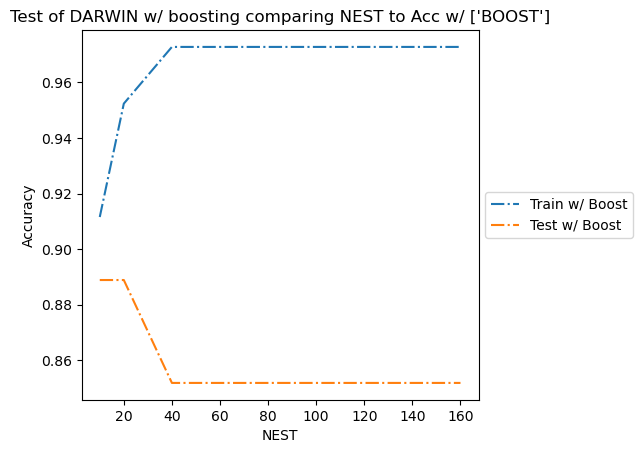

In [21]:
test_boosting_darwin.Graph(xaxis='NEST', include=['BOOST'])

Test boosting on Arrhythmia

In [ ]:
test_boosting_arryhthmia

Guide:\
When creating model object params are:\
&nbsp;&nbsp;&nbsp;&nbsp;    datasetName = name of dataset from dataset_names array\
&nbsp;&nbsp;&nbsp;&nbsp;    maxIter = maxIterations allowed in model\
&nbsp;&nbsp;&nbsp;&nbsp;    L2 = array of L2 values we want to test (so C) [$C_1$,$C_2$,..]\
 &nbsp;&nbsp;&nbsp;&nbsp;   nEstimators = array of nEstimators we wanna test [5,10,100,etc]\
  &nbsp;&nbsp;&nbsp;&nbsp;  bagging = array of decimals for the bagging fraction we want to test [0.1,0.5,etc]\
  &nbsp;&nbsp;&nbsp;&nbsp;  modelTitle = name that will appear atop of graph. Helps w/ keeping graphs organized.\
  &nbsp;&nbsp;&nbsp;&nbsp;  \
When graphing params are: \
   &nbsp;&nbsp;&nbsp;&nbsp; *xaxis = will tell the program what we want on xaxis can be: NEST, BAG, L2 (self explanatory)\
 &nbsp;&nbsp;&nbsp;&nbsp;   *include = array telling the program what data we want plotted can be: NEST, BAG, L2\
  &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;      **IMPORTANT: whatever xaxis is cannot be included in the include array!\
   &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;     **E.g.\
   &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;     **model.Graph("NEST",["L2","BAG"])  -  will work, will tell program to put nEstimators on xaxis, and graph L2 and Bag values\
   &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; **model.Graph("NEST',["L2","BAG","NEST"])  -  will not work as NEST is already on the xaxis.

Example Below: Note, training will take time as you are training len(L2) x len(nEst) x len(bagging)

In [101]:
testModel=Models('wdbc',5000,[0.1,0.5,1,5,10,50,500],[10,20,40,80,160],[0.2,0.35,0.5,0.75,1],"Test of wdbc")
testModel.Train()

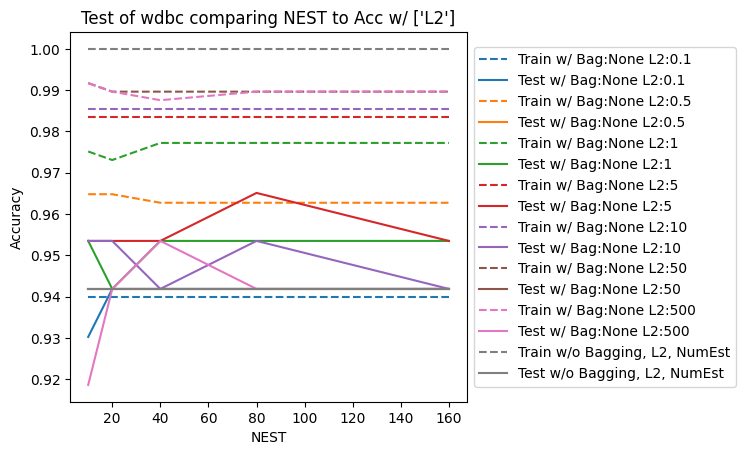

In [102]:
testModel.Graph('NEST',["L2"])

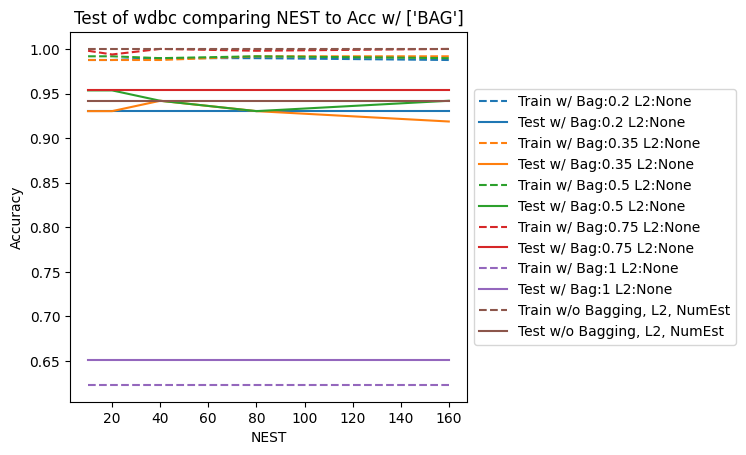

In [103]:
testModel.Graph('NEST',["BAG"])

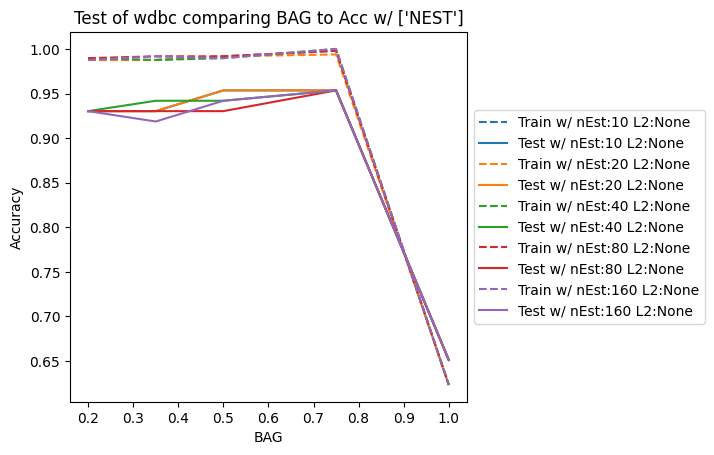

In [104]:
testModel.Graph('BAG',["NEST"])

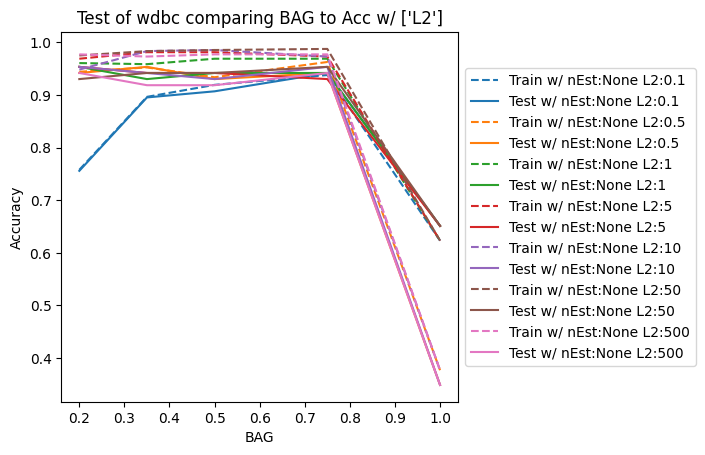

In [105]:
testModel.Graph('BAG',["L2"])

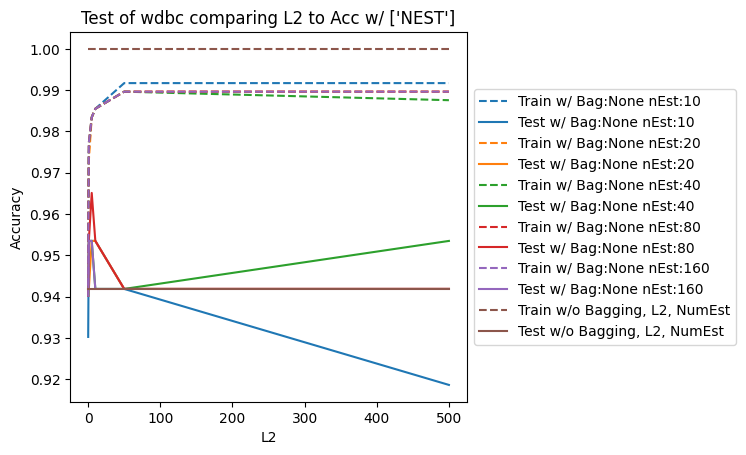

In [106]:
testModel.Graph('L2',["NEST"])

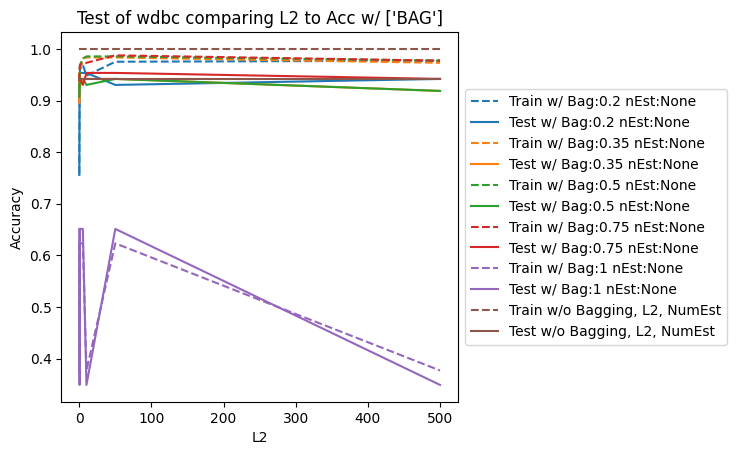

In [107]:
testModel.Graph('L2',["BAG"])

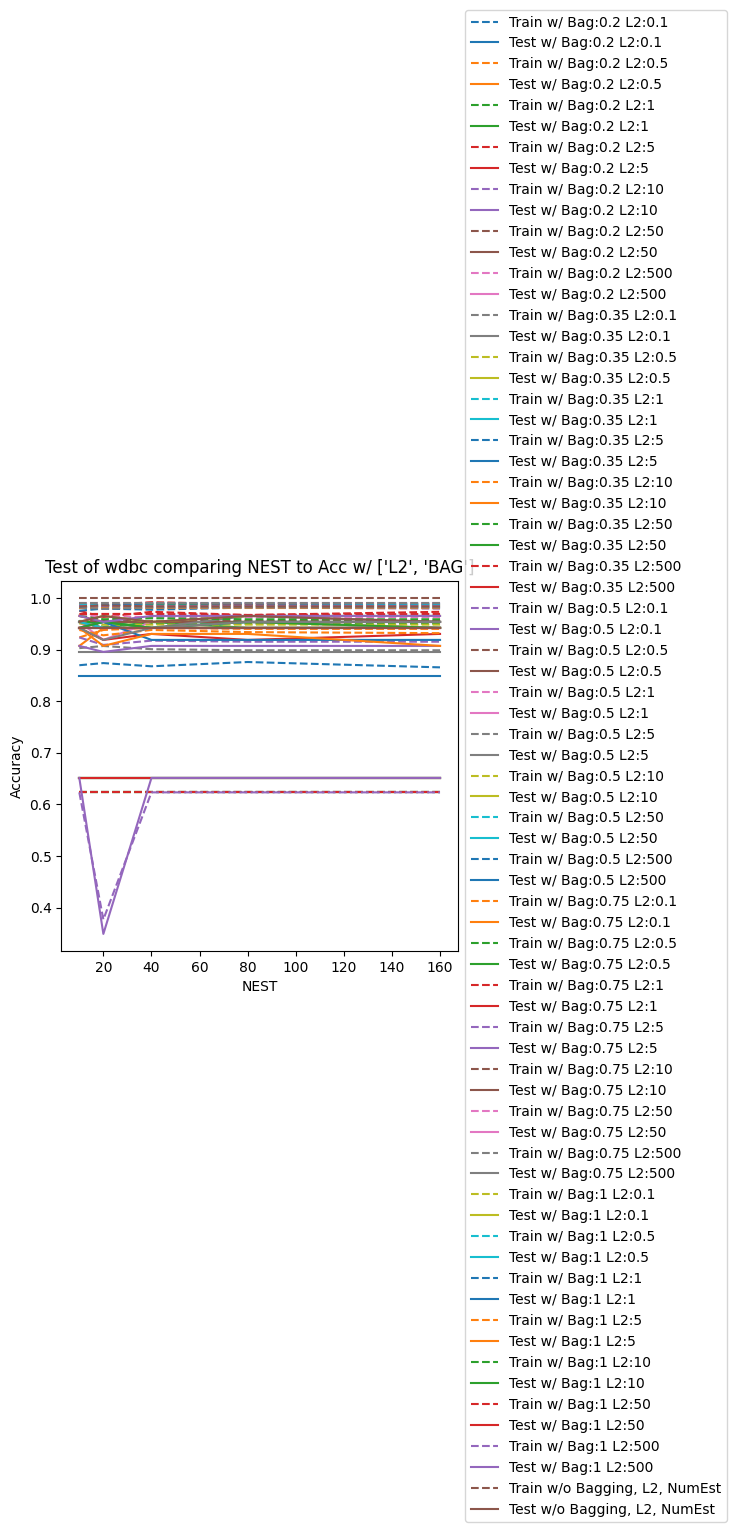

In [108]:
testModel.Graph('NEST',["L2","BAG"])

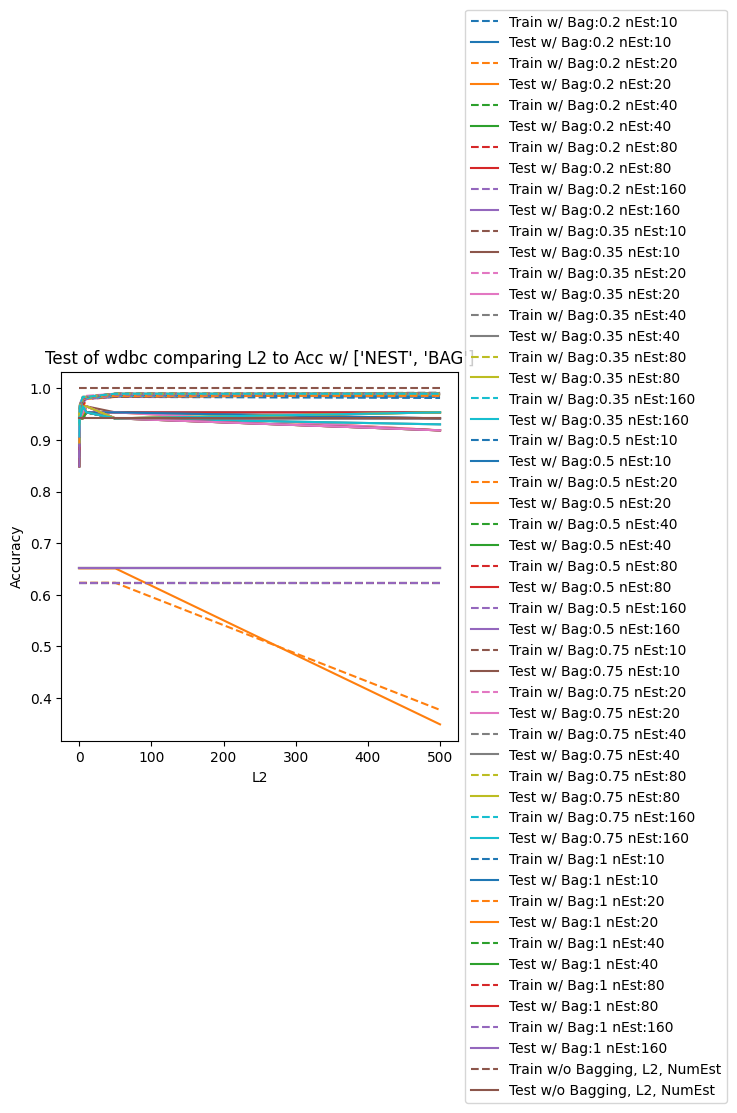

In [109]:
testModel.Graph('L2',["NEST","BAG"])

TypeError: 'NoneType' object is not iterable

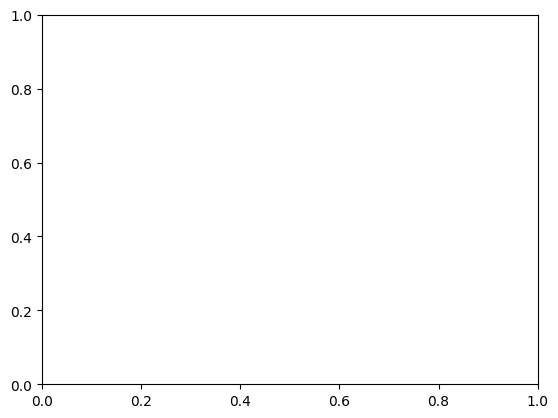

In [10]:
testModel.Graph('BAG',["L2","NEST"])

In [15]:
arrhythmiaModel=Models('arrhythmia',10000,[0.1,0.5,1,2.5,5,10,25,50,100,150,250,500],[5,10,20,50,100,200,1000],[0.1,0.25,0.5,0.75,1],"Arrhythmia")
arrhythmiaModel.Train()

[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    5.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    4.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    4.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    5.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Starting L2Reg


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    6.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    5.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    5.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    5.9s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    5.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    5.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    6.6s finished
[Parallel(n_jobs=-1)]: Using backend Loky

Starting L2Reg


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    7.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    7.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    8.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    7.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    7.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    7.9s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    6.7s finished
[Parallel(n_jobs=-1)]: Using backend Loky

Starting L2Reg


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.8s finished
[Parallel(n_jobs=-1)]: Using backend Loky

Starting L2Reg


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.8s finished
[Parallel(n_jobs=-1)]: Using backend Loky

Starting L2Reg


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.6s finished
[Parallel(n_jobs=-1)]: Using backend Loky

Starting L2Reg


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.6s finished
[Parallel(n_jobs=-1)]: Using backend Loky

Starting L2Reg


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.9s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.9s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.9s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.9s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.8s finished
[Parallel(n_jobs=-1)]: Using backend Loky

Starting L2Reg


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.3s finished
[Parallel(n_jobs=-1)]: Using backend Loky

Starting L2Reg


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.9s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    2.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    2.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    2.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    2.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    2.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    2.2s finished
[Parallel(n_jobs=-1)]: Using backend Loky

Starting L2Reg


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    2.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    2.9s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    3.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    3.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    2.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    3.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    2.7s finished
[Parallel(n_jobs=-1)]: Using backend Loky

Starting L2Reg


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    3.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    3.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    3.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    3.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    3.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    3.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    3.4s finished
[Parallel(n_jobs=-1)]: Using backend Loky

Starting L2Reg


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    4.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    4.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    3.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    3.9s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    3.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    4.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    3.5s finished
[Parallel(n_jobs=-1)]: Using backend Loky

Starting L2Reg


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    6.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    5.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    6.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    5.9s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    6.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    6.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    6.0s finished
[Parallel(n_jobs=-1)]: Using backend Loky

Starting L2Reg


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    5.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    6.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    5.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    4.9s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    4.9s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    5.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    4.5s finished
[Parallel(n_jobs=-1)]: Using backend Loky

Starting L2Reg


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    3.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    3.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    2.9s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    3.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    3.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    2.7s finished
[Parallel(n_jobs=-1)]: Using backend Loky

Starting L2Reg


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    2.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    2.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    2.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    4.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend Loky

Starting L2Reg


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:   20.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:   25.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:   23.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:   23.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:   24.3s finished
[Parallel(n_jobs=-1)]: Using backend Loky

Starting L2Reg


KeyboardInterrupt: 

TypeError: object of type 'NoneType' has no len()

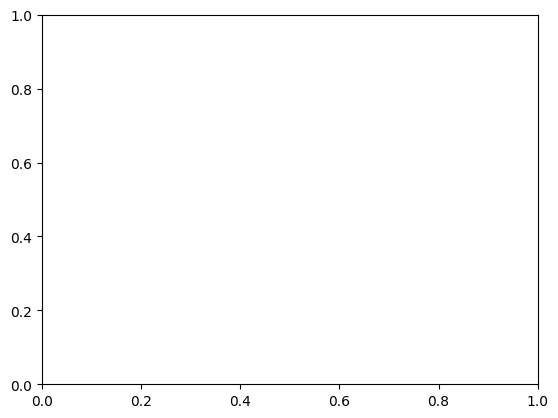

In [14]:
arrhythmiaModel.Graph("NEST",[None])







Previous Code

In [76]:
# Trains bagging model on top of logistic regression.
def bagging_log_regr(X_train, X_test, y_train, y_test, num_models, frac_samples, regularization=None):
    if (regularization == None):
        base = LogisticRegression(penalty=None, max_iter=5000)
    else:
        base = LogisticRegression(penalty='l2', C=regularization, max_iter=5000)
    bagging_classifier = BaggingClassifier(estimator=base, 
                                           n_estimators=num_models, 
                                           max_samples=frac_samples)
    bagging_classifier.fit(X_train, y_train)
    return bagging_classifier.score(X_train, y_train), bagging_classifier.score(X_test, y_test)

# Plots training and testing accuracy vs. number of base learners.
def plot_acc_vs_n_models(list_n_models, list_tr_acc, list_te_acc, nobag_tr_acc, nobag_te_acc):
    plt.plot(list_n_models, list_tr_acc, label='Train')
    plt.plot(list_n_models, list_te_acc, label='Test')
    nobag_tr = np.full(len(list_n_models), nobag_tr_acc)
    nobag_te = np.full(len(list_n_models), nobag_te_acc)
    plt.plot(list_n_models, nobag_tr, label='Train without bagging')
    plt.plot(list_n_models, nobag_te, label='Test without bagging')
    plt.legend(loc='best')
    plt.show()
    

1.0
0.9418604651162791
[0.9648033126293996, 0.9834368530020704, 0.9937888198757764, 0.989648033126294, 0.9917184265010351, 0.9917184265010351, 0.989648033126294]
[0.9418604651162791, 0.9302325581395349, 0.9534883720930233, 0.9418604651162791, 0.9418604651162791, 0.9418604651162791, 0.9418604651162791]


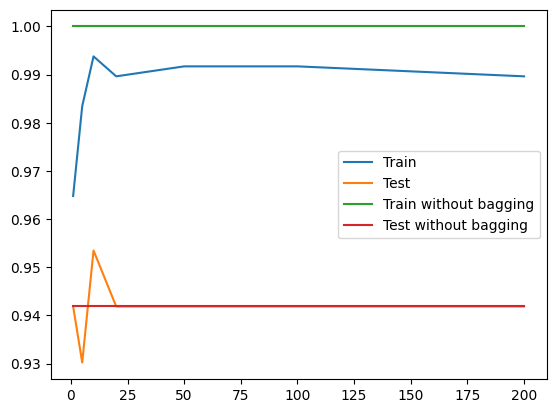

In [77]:
# Test on number of base learners

list_n_models = [1, 5, 10, 20, 50, 100, 200]

X_train, X_test, y_train, y_test = get_dataset('wdbc')

log_regr = LogisticRegression(penalty=None, max_iter=5000)
log_regr.fit(X_train, y_train)
nobag_tr_acc = log_regr.score(X_train, y_train)
nobag_te_acc = log_regr.score(X_test, y_test)
print(nobag_tr_acc)
print(nobag_te_acc)


list_tr_acc = []
list_te_acc = []
for n_models in list_n_models:
    tr_acc, te_acc = bagging_log_regr(X_train, X_test, y_train, y_test, n_models, 0.5)
    list_tr_acc.append(tr_acc)
    list_te_acc.append(te_acc)
print(list_tr_acc)
print(list_te_acc)
plot_acc_vs_n_models(list_n_models, list_tr_acc, list_te_acc, nobag_tr_acc, nobag_te_acc)

1.0
0.6617647058823529
[0.78125, 0.8541666666666666, 0.859375, 0.8880208333333334, 0.9010416666666666, 0.8932291666666666, 0.8958333333333334]
[0.6029411764705882, 0.6176470588235294, 0.6323529411764706, 0.6617647058823529, 0.6470588235294118, 0.6617647058823529, 0.6470588235294118]


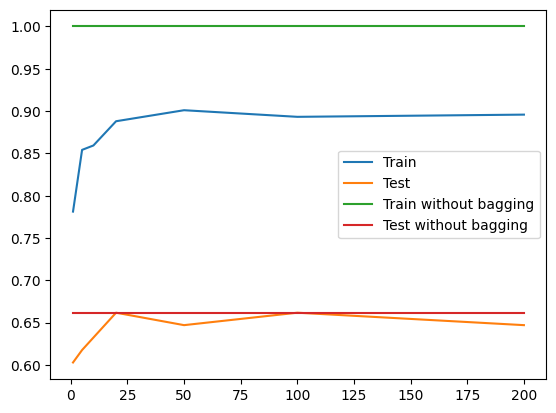

In [78]:
X_train, X_test, y_train, y_test = get_dataset('arrhythmia')

log_regr = LogisticRegression(penalty=None, max_iter=5000)
log_regr.fit(X_train, y_train)
nobag_tr_acc = log_regr.score(X_train, y_train)
nobag_te_acc = log_regr.score(X_test, y_test)
print(nobag_tr_acc)
print(nobag_te_acc)

list_tr_acc = []
list_te_acc = []
for n_models in list_n_models:
    tr_acc, te_acc = bagging_log_regr(X_train, X_test, y_train, y_test, n_models, 0.5)
    list_tr_acc.append(tr_acc)
    list_te_acc.append(te_acc)
print(list_tr_acc)
print(list_te_acc)
plot_acc_vs_n_models(list_n_models, list_tr_acc, list_te_acc, nobag_tr_acc, nobag_te_acc)


In [79]:
# Plots training and test accuracies vs number of examples used to train each base learners.
def plot_acc_vs_n_examples(list_n_examples, list_tr_acc, list_te_acc, nobag_tr_acc, nobag_te_acc):
    plt.plot(list_n_examples, list_tr_acc, label='Train')
    plt.plot(list_n_examples, list_te_acc, label='Test')
    nobag_tr = np.full(len(list_n_examples), nobag_tr_acc)
    nobag_te = np.full(len(list_n_examples), nobag_te_acc)
    plt.plot(list_n_examples, nobag_tr, label='Train without bagging')
    plt.plot(list_n_examples, nobag_te, label='Test without bagging')
    plt.legend(loc='best')
    plt.show()

1.0
0.9418604651162791
[0.9834368530020704, 0.989648033126294, 0.989648033126294, 0.9917184265010351, 0.9958592132505176]
[0.9418604651162791, 0.9302325581395349, 0.9418604651162791, 0.9534883720930233, 0.9302325581395349]


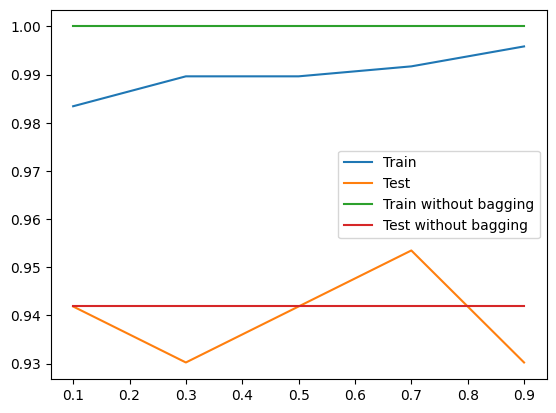

In [80]:
# Test on fraction of examples used to train each base learners

list_n_examples = [0.1, 0.3, 0.5, 0.7, 0.9]

X_train, X_test, y_train, y_test = get_dataset('wdbc')

log_regr = LogisticRegression(penalty=None, max_iter=5000)
log_regr.fit(X_train, y_train)
nobag_tr_acc = log_regr.score(X_train, y_train)
nobag_te_acc = log_regr.score(X_test, y_test)
print(nobag_tr_acc)
print(nobag_te_acc)


list_tr_acc = []
list_te_acc = []
for n_examples in list_n_examples:
    tr_acc, te_acc = bagging_log_regr(X_train, X_test, y_train, y_test, 10, n_examples)
    list_tr_acc.append(tr_acc)
    list_te_acc.append(te_acc)
print(list_tr_acc)
print(list_te_acc)
plot_acc_vs_n_examples(list_n_examples, list_tr_acc, list_te_acc, nobag_tr_acc, nobag_te_acc)

1.0
0.6617647058823529
[0.625, 0.7760416666666666, 0.8567708333333334, 0.9322916666666666, 0.9557291666666666]
[0.5735294117647058, 0.6176470588235294, 0.6323529411764706, 0.6470588235294118, 0.6470588235294118]


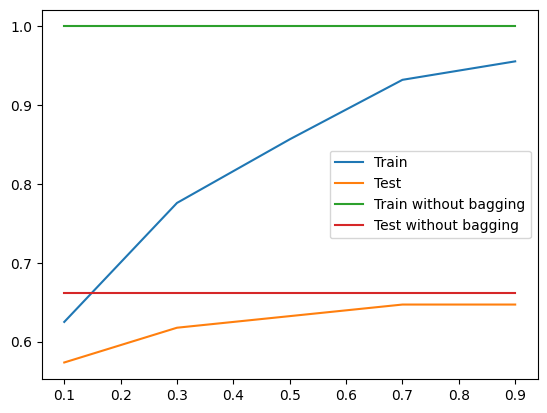

In [81]:
X_train, X_test, y_train, y_test = get_dataset('arrhythmia')

log_regr = LogisticRegression(penalty=None, max_iter=5000)
log_regr.fit(X_train, y_train)
nobag_tr_acc = log_regr.score(X_train, y_train)
nobag_te_acc = log_regr.score(X_test, y_test)
print(nobag_tr_acc)
print(nobag_te_acc)


list_tr_acc = []
list_te_acc = []
for n_examples in list_n_examples:
    tr_acc, te_acc = bagging_log_regr(X_train, X_test, y_train, y_test, 10, n_examples)
    list_tr_acc.append(tr_acc)
    list_te_acc.append(te_acc)
print(list_tr_acc)
print(list_te_acc)
plot_acc_vs_n_examples(list_n_examples, list_tr_acc, list_te_acc, nobag_tr_acc, nobag_te_acc)

In [82]:
# Plots training and test accuracies vs C (inverse of regularization strength)
def plot_acc_vs_C(list_C, list_tr_acc, list_te_acc, list_nobag_tr_acc, list_nobag_te_acc):
    plt.plot(list_C, list_tr_acc, label='Train w/ bagging')
    plt.plot(list_C, list_te_acc, label='Test w/ bagging')
    plt.plot(list_C, list_nobag_tr_acc, label='Train w/o bagging')
    plt.plot(list_C, list_nobag_te_acc, label='Test w/o bagging')
    plt.legend(loc='best')
    plt.show()

[0.9399585921325052, 0.9648033126293996, 0.9772256728778468, 0.9834368530020704, 0.9855072463768116, 0.989648033126294, 0.9917184265010351, 0.9875776397515528]
[0.9418604651162791, 0.9418604651162791, 0.9534883720930233, 0.9534883720930233, 0.9534883720930233, 0.9418604651162791, 0.9302325581395349, 0.9534883720930233]
[0.917184265010352, 0.9544513457556936, 0.9565217391304348, 0.9813664596273292, 0.9834368530020704, 0.9875776397515528, 0.9855072463768116, 0.9875776397515528]
[0.9069767441860465, 0.9534883720930233, 0.9534883720930233, 0.9534883720930233, 0.9534883720930233, 0.9418604651162791, 0.9302325581395349, 0.9186046511627907]


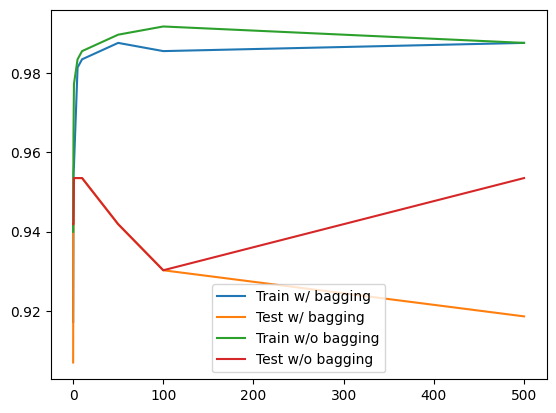

In [83]:
# Test on C

list_C = [0.1, 0.5, 1, 5, 10, 50, 100, 500]

X_train, X_test, y_train, y_test = get_dataset('wdbc')

list_nobag_tr_acc = []
list_nobag_te_acc = []
list_tr_acc = []
list_te_acc = []
for C in list_C:
    log_regr = LogisticRegression(penalty='l2', C=C, max_iter=5000)
    log_regr.fit(X_train, y_train)
    list_nobag_tr_acc.append(log_regr.score(X_train, y_train))
    list_nobag_te_acc.append(log_regr.score(X_test, y_test))
    tr_acc, te_acc = bagging_log_regr(X_train, X_test, y_train, y_test, 10, 0.5, regularization=C)
    list_tr_acc.append(tr_acc)
    list_te_acc.append(te_acc)
print(list_nobag_tr_acc)
print(list_nobag_te_acc)
print(list_tr_acc)
print(list_te_acc)
plot_acc_vs_C(list_C, list_tr_acc, list_te_acc, list_nobag_tr_acc, list_nobag_te_acc)

[0.6432291666666666, 0.7786458333333334, 0.8229166666666666, 0.9375, 0.9609375, 0.9921875, 1.0, 1.0]
[0.5441176470588235, 0.6323529411764706, 0.6617647058823529, 0.6617647058823529, 0.6764705882352942, 0.6764705882352942, 0.6617647058823529, 0.6617647058823529]
[0.5885416666666666, 0.7083333333333334, 0.7317708333333334, 0.8046875, 0.8098958333333334, 0.8333333333333334, 0.8854166666666666, 0.8671875]
[0.47058823529411764, 0.6029411764705882, 0.6176470588235294, 0.6323529411764706, 0.6617647058823529, 0.6764705882352942, 0.6470588235294118, 0.6470588235294118]


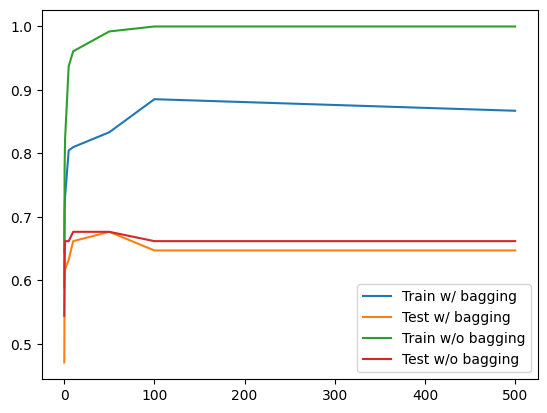

In [84]:
X_train, X_test, y_train, y_test = get_dataset('arrhythmia')

list_nobag_tr_acc = []
list_nobag_te_acc = []
list_tr_acc = []
list_te_acc = []
for C in list_C:
    log_regr = LogisticRegression(penalty='l2', C=C, max_iter=5000)
    log_regr.fit(X_train, y_train)
    list_nobag_tr_acc.append(log_regr.score(X_train, y_train))
    list_nobag_te_acc.append(log_regr.score(X_test, y_test))
    tr_acc, te_acc = bagging_log_regr(X_train, X_test, y_train, y_test, 10, 0.5, regularization=C)
    list_tr_acc.append(tr_acc)
    list_te_acc.append(te_acc)
print(list_nobag_tr_acc)
print(list_nobag_te_acc)
print(list_tr_acc)
print(list_te_acc)
plot_acc_vs_C(list_C, list_tr_acc, list_te_acc, list_nobag_tr_acc, list_nobag_te_acc)